In [1]:
import tonic
import torch
import numpy as np
import tonic.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display

<H2> Applying Transforms and Reading Data </H2>

In [2]:
n_steps = 8
sensor_size = (64, 64, 2)
denoise_filter_time = 500

In [3]:
class MergePolarity:
    def __init__(self):
        pass

    def __call__(Self, x):
        return x[:, 0, :, :] + x[:, 1, :, :] # Take both polarities

class PermuteChannels:
    def __call__(self, x):
        # If input is a NumPy array: (C, H, W)
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)  # Convert to tensor
        return x.permute(1, 2, 0)  # (C, H, W) → (H, W, C)

class NormalizeZeroToOne:
    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def __call__(self, x):
        x = (x - self.min) / (self.max - self.min)  # [0, 1]
        return x

In [4]:
directory_path = "C://Users/Sweta/Downloads/poker_dvs/"

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

class EventDataset(Dataset):
    def __init__(self, directory_path, transform=None):
        """
        Args:
            directory_path (str): Path to the directory containing AEDAT files.
            transform (callable, optional): Optional transform to be applied on the events.
        """
        self.directory_path = directory_path
        self.transform = transform
        self.files = []
        self.labels = []

        # Traverse the directory, and for each file, get the label and the AEDAT file path
        for label in os.listdir(directory_path):
            label_path = os.path.join(directory_path, label)
            if os.path.isdir(label_path):
                # For each class folder (e.g., hearts, spades, etc.)
                for file_name in os.listdir(label_path):
                    if file_name.endswith('.aedat'):
                        self.files.append(os.path.join(label_path, file_name))
                        self.labels.append(label)  # The folder name is the label

    def __len__(self):
        # Return the number of samples
        return len(self.files)

    def __getitem__(self, idx):
        # Load the AEDAT file and convert it to events
        file_path = self.files[idx]
        label = self.labels[idx]

        # Use your function that converts AEDAT file to events
        events = self.read_dvs_128(file_path)

        # Optionally apply any transformation (e.g., frame conversion)
        if self.transform:
            events = self.transform(events)
        
        # Convert events to tensor (if needed, e.g., for further processing)
        # events_tensor = torch.tensor(events, dtype=torch.float32)

        # Convert label to a tensor (you can map labels to integers if needed)
        label_tensor = torch.tensor(self.label_to_index(label), dtype=torch.long)

        return events, label_tensor

    def read_dvs_128(self, file_path):
        """Get the aer events from DVS with resolution of rows and cols are (128, 128)
    
        Parameters:
            filename: filename
    
        Returns:
            shape (tuple):
                (height, width) of the sensor array
            xytp: numpy structured array of events
        """
        data_version, data_start, dummy = tonic.io.read_aedat_header_from_file(file_path)
        all_events = tonic.io.get_aer_events_from_file(file_path, data_version, data_start)
        all_addr = all_events["address"]
        t = all_events["timeStamp"]
    
        x = (all_addr >> 8) & 0x007F
        y = (all_addr >> 1) & 0x007F
        p = all_addr & 0x1
    
        events = tonic.io.make_structured_array(x, y, t, p)
        return events

    def convert_aedat_to_events(self, file_path):
        # Call your function here to convert the AEDAT file to events.
        # Make sure the function returns the events as NumPy arrays or tensors.
        # Replace this with the actual function you've written to process AEDAT files.
        
        # Example:
        dataset = tonic.datasets.POKERDVS()
        events = dataset.read(file_path)  # Replace with your function
        return events

    def label_to_index(self, label):
        # You can map labels (e.g., 'hearts', 'spades') to integers (e.g., 0, 1, etc.)
        label_map = {'heart': 0, 'spade': 1, 'club': 2, 'diamond': 3}
        return label_map.get(label, -1)  # Default to -1 if label is not found


In [6]:
#Define Tansforms

frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=n_steps)
denoise_transform = tonic.transforms.Denoise(filter_time=denoise_filter_time)
merge_polarity_transform = MergePolarity()
permute_channel_transform = PermuteChannels()

transform = transforms.Compose([denoise_transform, frame_transform, merge_polarity_transform, permute_channel_transform])

In [7]:
#Read Dataset and Apply Transforms

dataset = EventDataset(directory_path = directory_path, transform=transform)

In [8]:
#Compute Global Max and Global Min for the entire dataset for normalisation

def compute_global_min_max(dataset):
    min_val, max_val = float('inf'), float('-inf')
    for i in range(len(dataset)):
        data, _ = dataset[i]
        data_min, data_max = data.min(), data.max()
        min_val = min(min_val, data_min)
        max_val = max(max_val, data_max)
    return min_val, max_val

global_min, global_max = compute_global_min_max(dataset)
global_min_int = int(global_min)
global_max_int = int(global_max) 
global_min_int, global_max_int

(0, 19)

In [9]:
#Add Normalisation to Transfoms

normalize_transform = NormalizeZeroToOne(global_min_int, global_max_int)

transform = transforms.Compose([denoise_transform, frame_transform, merge_polarity_transform, permute_channel_transform])

In [10]:
#Read Dataset and Apply Transforms

dataset = EventDataset(directory_path = directory_path, transform=transform)

<H2> Visualization </H2>

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_frames_without_polarity_permuted(data_tensor):
    """
    Plots individual image frames from a 3D tensor where the last dimension
    represents timesteps.

    Args:
        data_tensor (torch.Tensor or np.ndarray): A tensor/array of shape
                                                  [x_dim, y_dim, num_timesteps],
                                                  e.g., [34, 34, 16].
    """
    # Ensure the input is a NumPy array for Matplotlib
    if isinstance(data_tensor, torch.Tensor):
        # Move to CPU if it's on GPU, then convert to NumPy
        data_np = data_tensor.cpu().numpy()
    elif isinstance(data_tensor, np.ndarray):
        data_np = data_tensor
    else:
        raise TypeError("Input data_tensor must be a torch.Tensor or numpy.ndarray")

    # The number of timesteps is the size of the last dimension
    num_timesteps = data_np.shape[2]

    # Determine optimal subplot grid (e.g., 4 columns)
    n_cols = 8
    n_rows = 1

    # Create the figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    # Flatten the axes array for easier iteration, handling cases with 1 row/col
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes]) # Ensure it's an iterable array even for a single plot
    else:
        axes = axes.flatten()

    for i in range(num_timesteps):
        ax = axes[i]
        # Extract the 2D image for the current timestep (slice along the last dimension)
        frame = data_np[:, :, i]

        ax.imshow(frame) # Use 'gray' colormap for single-channel data
        ax.set_title(f'T{i+1}', fontsize=24) # Add title for each frame
        ax.axis("off") # Hide axis ticks and labels

    # Hide any unused subplots if the number of timesteps doesn't perfectly fill the grid
    for i in range(num_timesteps, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.suptitle('Image at Each Timestep', y=1.3, fontsize=28) # Add a main title
    plt.show() # Display the plot

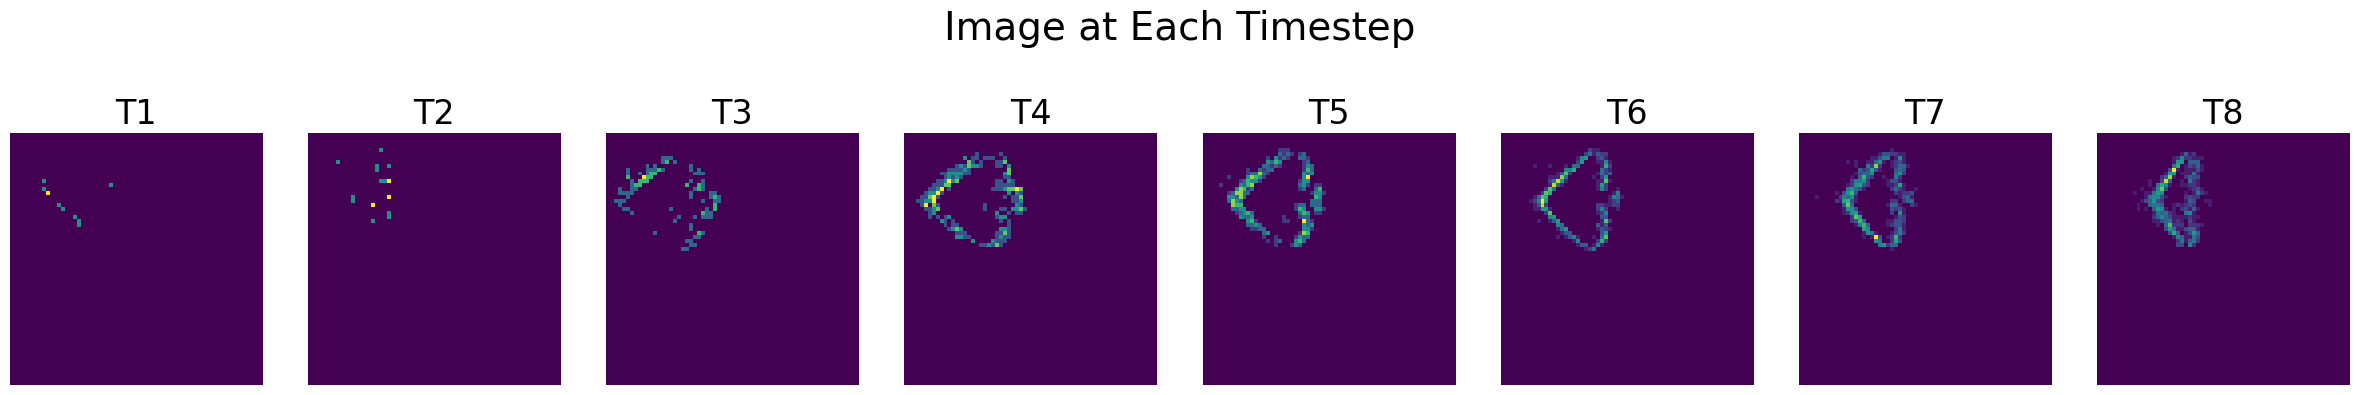

In [12]:
plot_frames_without_polarity_permuted(dataset[111][0])

In [13]:
import snntorch.spikeplot as splt
from IPython.display import HTML

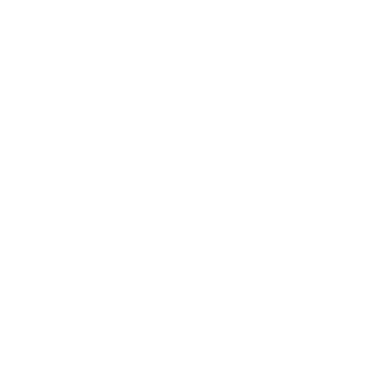

In [15]:
fig, ax = plt.subplots()
anim = splt.animator(dataset[111][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

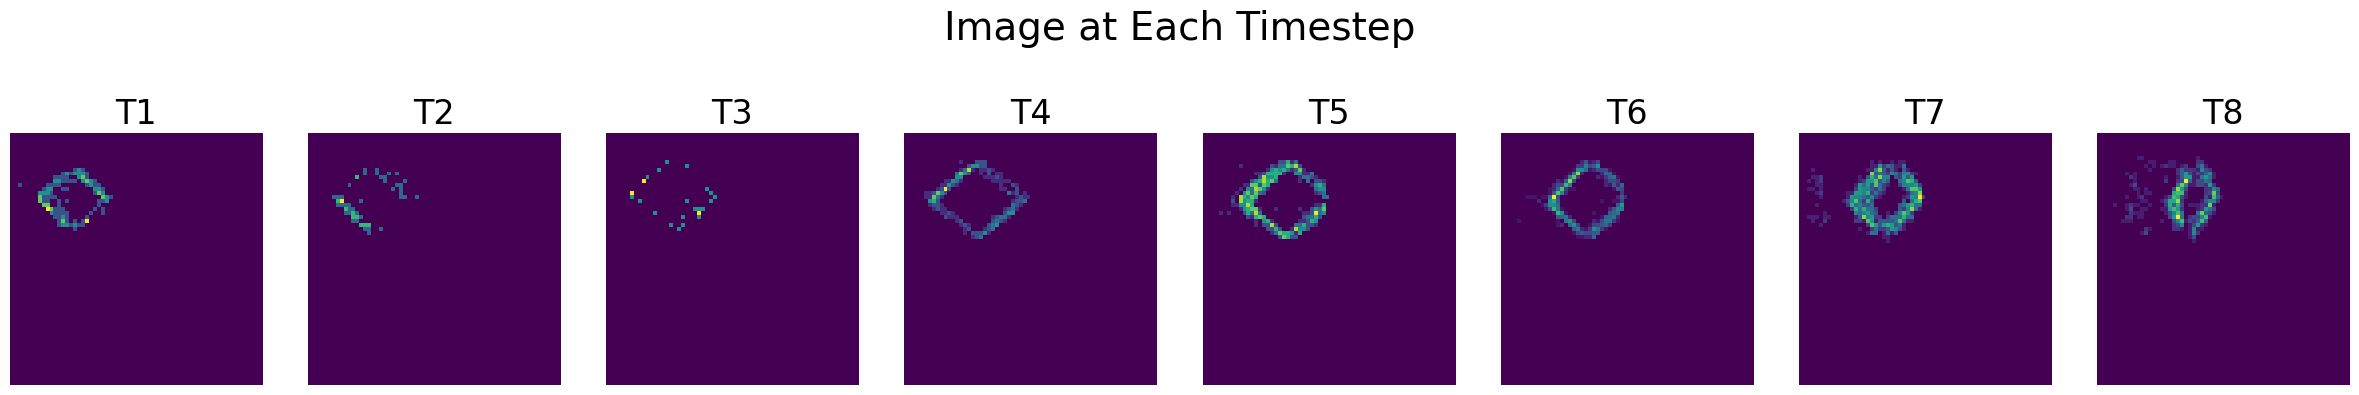

In [16]:
plot_frames_without_polarity_permuted(dataset[33][0])

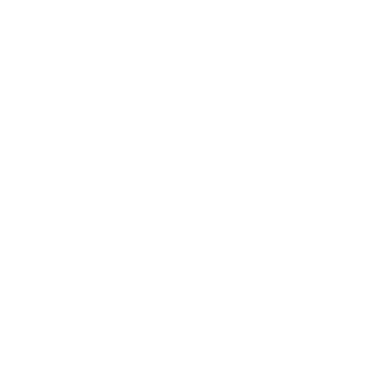

In [17]:
fig, ax = plt.subplots()
anim = splt.animator(dataset[33][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

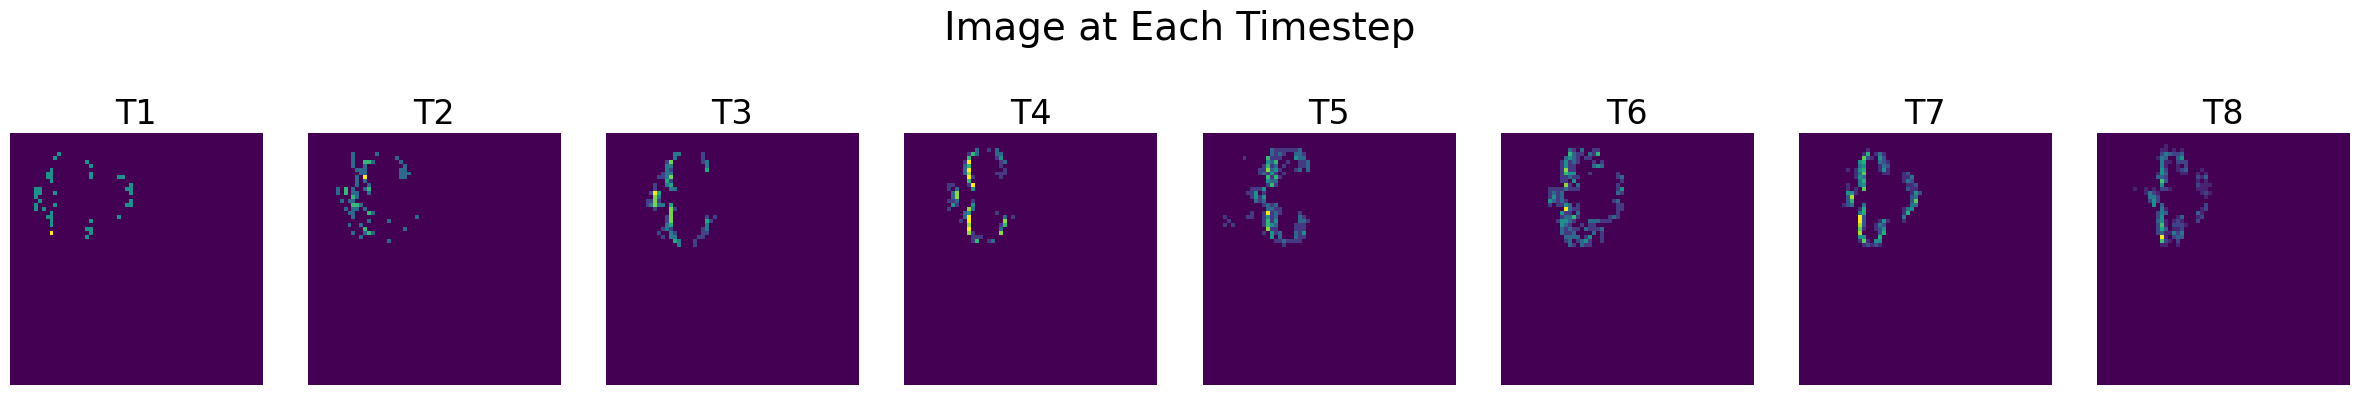

In [18]:
plot_frames_without_polarity_permuted(dataset[1][0])

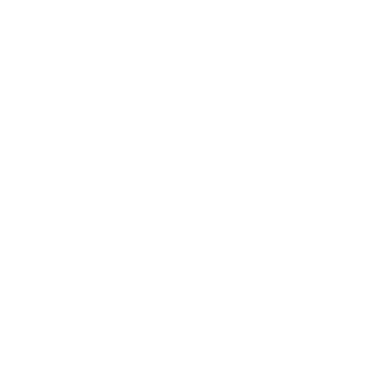

In [19]:
fig, ax = plt.subplots()
anim = splt.animator(dataset[1][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

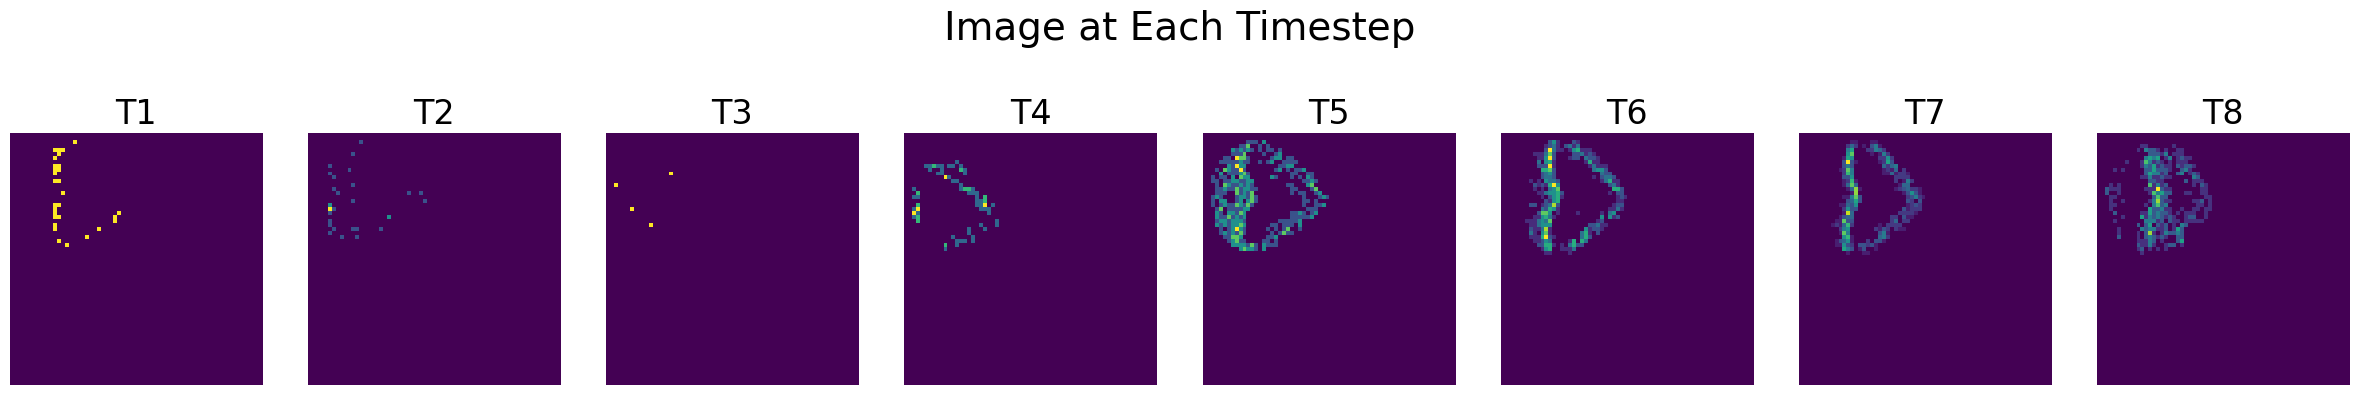

In [20]:
plot_frames_without_polarity_permuted(dataset[77][0])

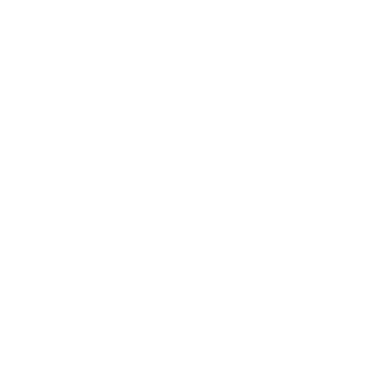

In [21]:
fig, ax = plt.subplots()
anim = splt.animator(dataset[77][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<H2> Train and Test Split</H2>

In [22]:
from collections import defaultdict
from torch.utils.data import DataLoader, Subset

# --- helpers ---------------------------------------------------------------
def get_labels(dataset):
    """
    Return list[int] labels. Works whether dataset stores ints, tensors, or strings.
    If strings are found, uses dataset.label_to_index to map to ints.
    """
    # Prefer stored labels if present to avoid loading every sample
    if hasattr(dataset, "targets"):
        labels = dataset.targets
    elif hasattr(dataset, "labels"):
        labels = dataset.labels
    else:
        # Fallback: index into the dataset (expects __getitem__ to return (x, y_tensor))
        out = []
        for i in range(len(dataset)):
            y = dataset[i][1]
            if isinstance(y, torch.Tensor):
                out.append(int(y.item()))
            else:
                out.append(int(y))
        return out

    # Normalize to ints
    out = []
    for y in labels:
        if isinstance(y, (int, np.integer)):
            out.append(int(y))
        elif isinstance(y, torch.Tensor):
            out.append(int(y.item()))
        elif isinstance(y, str):
            if hasattr(dataset, "label_to_index"):
                idx = dataset.label_to_index(y)
                if idx == -1:  # try singularize (e.g., "hearts" -> "heart")
                    key = y.lower().strip()
                    if key.endswith('s'):
                        idx = dataset.label_to_index(key[:-1])
                if idx == -1:
                    raise ValueError(f"Unknown string label '{y}'. Update label_to_index.")
                out.append(int(idx))
            else:
                raise ValueError("Dataset has string labels but no label_to_index method.")
        else:
            raise TypeError(f"Unsupported label type: {type(y)}")
    return out


def stratified_equal_test_split(labels, train_ratio=0.9, num_classes=4, seed=42, require_at_least=1):
    """
    Build a test set with EXACTLY the same number of samples per class.
    The final test size will be k_per_class * num_classes, where:
        k_per_class = min( floor(target_test_size/num_classes), min_class_count )
    If k_per_class < require_at_least and every class has >= require_at_least, it bumps to that.
    """
    N = len(labels)
    target_test_size = N - int(train_ratio * N)  # e.g., 131 - floor(0.9*131)=14
    rng = np.random.default_rng(seed)

    # group indices by class
    by_cls = defaultdict(list)
    for i, y in enumerate(labels):
        by_cls[int(y)].append(i)

    # sanity: make sure we actually saw num_classes classes
    classes = sorted(by_cls.keys())
    if len(classes) != num_classes:
        # still works, but warn in logs/print if needed
        pass

    # shuffle each class bucket
    for c in classes:
        rng.shuffle(by_cls[c])

    min_class_count = min(len(by_cls[c]) for c in classes)
    k_per_class = target_test_size // num_classes
    k_per_class = min(k_per_class, min_class_count)

    # optional lower bound (e.g., at least 1 per class) if feasible
    if k_per_class < require_at_least:
        if min_class_count >= require_at_least:
            k_per_class = require_at_least  # test size becomes require_at_least * num_classes
        else:
            # some class has fewer than require_at_least samples; keep k_per_class as-is
            pass

    # build test indices with exactly k_per_class per class
    test_idx = []
    for c in classes:
        k = min(k_per_class, len(by_cls[c]))
        test_idx.extend(by_cls[c][:k])

    # remaining -> train
    test_idx = sorted(test_idx)
    train_idx = sorted(set(range(N)) - set(test_idx))

    return train_idx, test_idx, k_per_class, len(test_idx)

def class_counts_from_indices(labels, indices):
    d = defaultdict(int)
    for i in indices:
        d[labels[i]] += 1
    return dict(sorted(d.items()))


In [23]:
# --- split + loaders -------------------------------------------------------

train_ratio = 0.9
batch_size = 16
NUM_CLASSES = 4

labels = get_labels(dataset)
train_idx, test_idx, k_per_class, actual_test_size = stratified_equal_test_split(
    labels, train_ratio=train_ratio, num_classes=NUM_CLASSES, seed=42, require_at_least=1
)

train_dataset = Subset(dataset, train_idx)
test_dataset  = Subset(dataset, test_idx)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(test_dataset,  batch_size=batch_size*2, shuffle=False)  # balanced by construction

# sanity prints
print(f"Total={len(labels)}  Train={len(train_dataset)}  Test={len(test_dataset)}")
print(f"Balanced test per class = {k_per_class}  -> Test size = {actual_test_size}")
print("Train class counts:", class_counts_from_indices(labels, train_idx))
print("Test  class counts:", class_counts_from_indices(labels, test_idx))

Total=131  Train=119  Test=12
Balanced test per class = 3  -> Test size = 12
Train class counts: {0: 20, 1: 32, 2: 27, 3: 40}
Test  class counts: {0: 3, 1: 3, 2: 3, 3: 3}


In [24]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

print("Train batch - images shape:", images.shape)
print("Train batch - labels shape:", labels.shape)

Train batch - images shape: torch.Size([16, 64, 64, 8])
Train batch - labels shape: torch.Size([16])


In [25]:
data_iter = iter(testloader)
images, labels = next(data_iter)

print("Train batch - images shape:", images.shape)
print("Train batch - labels shape:", labels.shape)

Train batch - images shape: torch.Size([12, 64, 64, 8])
Train batch - labels shape: torch.Size([12])


<H2> Layers </H2>

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

<h3> LIF Hyperparameters </H3>

In [27]:
dt = 5
a = 0.25
aa = 0.5  
Vth = 0.3
tau = 0.35

<H3> LIF Implementation </H3>

In [28]:
class SpikeAct(torch.autograd.Function):
    """
    Spiking activation with a box (straight-through) surrogate gradient.

    Forward:
        Outputs 1.0 where input > Vth, else 0.0. (Uses global Vth.)

    Backward:
        Approximates d(spike)/d(input) with a constant slope that is non-zero
        only inside a window of width 2*aa centered at 0:
            grad ≈ 1/(2*aa) if |input| < aa, otherwise 0.
        The upstream gradient is scaled by this surrogate. (Uses global aa.)
    """
    @staticmethod
    def forward(ctx, input):
        # Save input for computing the surrogate gradient in backward()
        ctx.save_for_backward(input)
        # Binary spike: 1.0 if input exceeds threshold, 0.0 otherwise
        output = torch.gt(input, Vth) 
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve saved input from forward pass
        input, = ctx.saved_tensors 
        grad_input = grad_output.clone()
        # Box surrogate: constant slope within |input| < aa, zero outside
        hu = abs(input) < aa
        hu = hu.float() / (2 * aa)
        # Return Scaled upstream gradient by the surrogate derivative
        return grad_input * hu

class LIFSpike(nn.Module):
    """
    Leaky Integrate-and-Fire (LIF) spiking layer with a surrogate-gradient spike nonlinearity.

    Usage
    -----
    Treat this like a temporal activation: pass in a tensor with an explicit time axis
    on the last dimension and get a same-shaped tensor of spikes (0/1 floats) out.

        Input shape:  (..., T)   # T = number of time steps, last dim
        Output shape: (..., T)   # spike train per element

    Dynamics
    --------
    For each element and time step t:
        u[t+1] = tau * u[t] * (1 - o[t]) + x[t]          # leak + input; multiplicative reset
        o[t+1] = SpikeAct(u[t+1])                        # binary spike with surrogate gradient

    Notes
    -----
    - `tau` is the membrane decay (0 <= tau < 1). This function uses a module/global `tau`
      unless provided explicitly to `state_update`.
    - The multiplicative factor (1 - o[t]) implements a soft reset/refractory behavior:
      when a spike occurs at t, carryover from the previous potential is suppressed.
    - `SpikeAct` provides a straight-through surrogate gradient so training can use BPTT.
      (It relies on global parameters such as `Vth` and `aa`.)
    """

    def __init__(self):
        super(LIFSpike, self).__init__()

    def forward(self, x):
        # Number of time steps assumed on the last axis
        nsteps = x.shape[-1]

        # Membrane potential state for the current step (no time dimension)
        u   = torch.zeros(x.shape[:-1] , device=x.device)
        # Preallocate spike train output; same shape as input
        out = torch.zeros(x.shape, device=x.device)
        
        # Unroll over time. At t=0, use a zero previous spike (out[..., 0] is initialized to 0).
        for step in range(nsteps):
            u, out[..., step] = self.state_update(u, out[..., max(step-1, 0)], x[..., step])
        return out
    
    def state_update(self, u_t_n1, o_t_n1, W_mul_o_t1_n, tau=tau):

        # Update membrane potential with leak/decay and optional reset after a spike
        # u_{t+1} = tau * u_t * (1 - o_t) + input_t
        u_t1_n1 = tau * u_t_n1 * (1 - o_t_n1) + W_mul_o_t1_n

        # Produce spike using surrogate-gradient activation
        o_t1_n1 = SpikeAct.apply(u_t1_n1)
        return u_t1_n1, o_t1_n1

<H3> Linear </H3>

In [29]:
class tdLinear(nn.Linear):

    """
    Time-distributed fully connected layer.

    Applies the same `nn.Linear(in_features, out_features)` to every time step of
    an input shaped `(N, C_in, T)` and returns `(N, C_out, T)`. Optionally applies
    a normalization module over a 5D view `(N, C_out, 1, 1, T)` (e.g., `BatchNorm3d`)
    and then an activation/spiking module.

    Args:
        in_features (int): Number of features per time step (C_in).
        out_features (int): Number of output features per time step (C_out).
        bias (bool): If True, adds a learnable bias to the linear map.
        bn (nn.Module | None): Normalization module applied after the linear map.
            It should accept a 5D tensor `(N, C, D, H, W)`; we pass `(N, C, 1, 1, T)`.
        spike (callable | nn.Module | None): Elementwise activation (e.g., `LIFSpike`)
            that takes and returns `(N, C_out, T)`.

    Notes:
        - Internally we transpose to `(N, T, C_in)` so `F.linear` treats the last
          dimension as features, then transpose back to `(N, C_out, T)`.
        - Weights are shared across all time steps (hence “time-distributed”).
    """
    
    def __init__(self, 
                in_features,
                out_features,
                bias=True,
                bn=None,
                spike=None):
        assert type(in_features) == int, 'inFeatures should not be more than 1 dimesnion. It was: {}'.format(in_features.shape)
        assert type(out_features) == int, 'outFeatures should not be more than 1 dimesnion. It was: {}'.format(out_features.shape)

        super(tdLinear, self).__init__(in_features, out_features, bias=bias)

        self.bn = bn
        self.spike = spike
        

    def forward(self, x):
        """
        x : (N,C,T)
        """     
        x = x.transpose(1, 2) # (N, T, C)
        y = F.linear(x, self.weight, self.bias)
        y = y.transpose(1, 2)# (N, C, T)

        # Optional normalization across time using a 3D BN-style module
        if self.bn is not None:
            y = y[:,:,None,None,:]
            y = self.bn(y)
            y = y[:,:,0,0,:]

        # Optional activation/spiking nonlinearity (e.g., LIFSpike)
        if self.spike is not None:
            y = self.spike(y)
        return y


<h3>Convolution </h3>

In [30]:
class tdConv(nn.Conv3d):

    """
    Time-distributed convolution implemented with Conv3d.

    This layer expects input shaped (N, C_in, T, H, W) and applies the same
    convolution independently to each time slice (depth).

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int | Tuple[int, int]): Spatial kernel (kH, kW). The temporal
            kernel is forced to 1, so no temporal mixing occurs.
        stride (int | Tuple[int, int], optional): Spatial stride. Temporal stride
            is forced to 1. Default: 1.
        padding (int | Tuple[int, int], optional): Spatial padding. Temporal padding
            is forced to 0. Default: 0.
        dilation (int | Tuple[int, int], optional): Spatial dilation. Temporal
            dilation is forced to 1. Default: 1.
        groups (int, optional): Convolution groups. Default: 1.
        bias (bool, optional): Add learnable bias. Default: True.
        bn (nn.Module | None, optional): Optional normalization module applied to
            the 5D tensor (e.g., nn.BatchNorm3d). Default: None.
        spike (nn.Module | Callable | None, optional): Optional activation/spiking
            nonlinearity applied after normalization (e.g., LIFSpike). Default: None.
        is_first_conv (bool, optional): Flag kept for API symmetry; not used in
            forward(). Default: False.
    """
    
    def __init__(self, 
                in_channels, 
                out_channels,  
                kernel_size,
                stride=1,
                padding=0,
                dilation=1,
                groups=1,
                bias=True,
                bn=None,
                spike=None,
                is_first_conv=False):

        # kernel
        if type(kernel_size) == int:
            kernel = (kernel_size, kernel_size, 1)
        elif len(kernel_size) == 2:
            kernel = (kernel_size[0], kernel_size[1], 1)
        else:
            raise Exception('kernelSize can only be of 1 or 2 dimension. It was: {}'.format(kernel_size.shape))

        # stride
        if type(stride) == int:
            stride = (stride, stride, 1)
        elif len(stride) == 2:
            stride = (stride[0], stride[1], 1)
        else:
            raise Exception('stride can be either int or tuple of size 2. It was: {}'.format(stride.shape))

        # padding
        if type(padding) == int:
            padding = (padding, padding, 0)
        elif len(padding) == 2:
            padding = (padding[0], padding[1], 0)
        else:
            raise Exception('padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        # dilation
        if type(dilation) == int:
            dilation = (dilation, dilation, 1)
        elif len(dilation) == 2:
            dilation = (dilation[0], dilation[1], 1)
        else:
            raise Exception('dilation can be either int or tuple of size 2. It was: {}'.format(dilation.shape))

        super(tdConv, self).__init__(in_channels, out_channels, kernel, stride, padding, dilation, groups,
                                        bias=bias)
        self.bn = bn
        self.spike = spike
        self.is_first_conv = is_first_conv

    def forward(self, x):
        # Spatial conv applied 
        x = F.conv3d(x, self.weight, self.bias,
                        self.stride, self.padding, self.dilation, self.groups)

        # Optional normalization across time using a 3D BN-style module
        if self.bn is not None:
            x = self.bn(x)

        # Optional activation/spiking nonlinearity (e.g., LIFSpike)
        if self.spike is not None:
            x = self.spike(x)
        return x

<h3> Conv Transpose </h3>

In [31]:
class tdConvTranspose(nn.ConvTranspose3d):

    """
    Time-distributed transposed convolution (a.k.a. deconvolution) via ConvTranspose3d.

    Applies the same *spatial* transposed convolution independently to every time slice.

        Input:  (N, C_in, T, H, W)
        Output: (N, C_out, T, H_out, W_out)

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int | Tuple[int, int]): Spatial kernel (kH, kW). Temporal kernel is forced to 1.
        stride (int | Tuple[int, int], optional): Spatial stride; temporal stride forced to 1. Default: 1.
        padding (int | Tuple[int, int], optional): Spatial padding; temporal padding forced to 0. Default: 0.
        output_padding (int | Tuple[int, int] | Tuple[int, int, int], optional):
            Extra spatial size added to the output shape (opH, opW[, opT]).
            If 2D is given, temporal opT is set to 0. Default: 0.
        dilation (int | Tuple[int, int], optional): Spatial dilation; temporal dilation forced to 1. Default: 1.
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1.
        bias (bool, optional): If True, adds a learnable bias. Default: True.
        bn (nn.Module | None, optional): Optional normalization module for 5D tensors (e.g., nn.BatchNorm3d).
        spike (nn.Module | Callable | None, optional): Optional activation/spiking nonlinearity (e.g., LIFSpike).
    """
    
    def __init__(self, 
                in_channels, 
                out_channels,  
                kernel_size,
                stride=1,
                padding=0,
                output_padding=0,
                dilation=1,
                groups=1,
                bias=True,
                bn=None,
                spike=None):

        # kernel
        if type(kernel_size) == int:
            kernel = (kernel_size, kernel_size, 1)
        elif len(kernel_size) == 2:
            kernel = (kernel_size[0], kernel_size[1], 1)
        else:
            raise Exception('kernelSize can only be of 1 or 2 dimension. It was: {}'.format(kernel_size.shape))

        # stride
        if type(stride) == int:
            stride = (stride, stride, 1)
        elif len(stride) == 2:
            stride = (stride[0], stride[1], 1)
        else:
            raise Exception('stride can be either int or tuple of size 2. It was: {}'.format(stride.shape))

        # padding
        if type(padding) == int:
            padding = (padding, padding, 0)
        elif len(padding) == 2:
            padding = (padding[0], padding[1], 0)
        else:
            raise Exception('padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        # dilation
        if type(dilation) == int:
            dilation = (dilation, dilation, 1)
        elif len(dilation) == 2:
            dilation = (dilation[0], dilation[1], 1)
        else:
            raise Exception('dilation can be either int or tuple of size 2. It was: {}'.format(dilation.shape))


        # output padding
        if type(output_padding) == int:
            output_padding = (output_padding, output_padding, 0)
        elif len(output_padding) == 2:
            output_padding = (output_padding[0], output_padding[1], 0)
        elif len(output_padding) == 3:
            output_padding = output_padding
        else:
            raise Exception('output_padding can be either int or tuple of size 2 or tuple of size 3. It was: {}'.format(padding.shape))

        super().__init__(in_channels, out_channels, kernel, stride, padding, output_padding, groups,
                                        bias=bias, dilation=dilation)

        self.bn = bn
        self.spike = spike

    def forward(self, x):
        # Spatial transpose conv applied 
        x = F.conv_transpose3d(x, self.weight, self.bias,
                        self.stride, self.padding, 
                        self.output_padding, self.groups, self.dilation)

        # Optional normalization across time using a 3D BN-style module
        if self.bn is not None:
            x = self.bn(x)

        # Optional activation/spiking nonlinearity (e.g., LIFSpike)
        if self.spike is not None:
            x = self.spike(x)
        return x

<h3> Batch Norm</h3>

In [32]:
class tdBatchNorm(nn.BatchNorm2d):
    """
    Time-domain BatchNorm (tdBN) for 5D inputs in spiking/temporal networks.

    Computes per-channel statistics across batch, time, and spatial axes and
    applies BatchNorm to each time slice. After normalization, outputs are
    scaled by `alpha * Vth` so activations stay in the range of the spiking
    threshold.

    Expected shapes
    ---------------
    Input : (N, C, T, H, W)
    Output: (N, C, T, H, W)

    Training behavior
    -----------------
    - Mean and variance are computed over dims [0, 2, 3, 4] → (N, T, H, W).
    - Running stats are updated via EMA using `momentum`.
    - We correct the biased variance (computed with `unbiased=False`) to an
      unbiased estimate when updating `running_var`.

    Inference behavior
    ------------------
    - Uses `running_mean` and `running_var` as usual.

    Args
    ----
    num_features (int): Same as nn.BatchNorm2d (C).
    eps (float): Same as nn.BatchNorm2d.
    momentum (float): Same as nn.BatchNorm2d.
    alpha (float): Post-normalization scale factor; output is multiplied by
        `alpha * Vth` before the optional affine transform.
    affine (bool): Same as nn.BatchNorm2d (learnable gamma/beta).
    track_running_stats (bool): Same as nn.BatchNorm2d.

    Notes
    -----
    - `Vth` is expected to be a global scalar defined elsewhere.
    - This class reuses buffers/parameters from BatchNorm2d but operates on 5D inputs.
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.2, alpha=0.9, affine=True, track_running_stats=True):
        super(tdBatchNorm, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, input):
        # Expect a 5D tensor (N, C, T, H, W)
        # (We only use BatchNorm2d's buffers/params; not its 4D forward.)
        exponential_average_factor = 0.0

        # Determine EMA factor for running stats
        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  
                    # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  
                    # use exponential moving average
                    exponential_average_factor = self.momentum

        # Compute per-channel stats over (N, T, H, W)
        if self.training:
            mean = input.mean([0, 2, 3, 4])
            # use biased var in train
            var = input.var([0, 2, 3, 4], unbiased=False)
            n = input.numel() / input.size(1)

            # Update running stats (unbiased correction for var)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        # Normalize and scale to spiking range: alpha * Vth * (x - mu) / sqrt(var + eps)
        input = self.alpha * Vth * (input - mean[None, :, None, None, None]) / (torch.sqrt(var[None, :, None, None, None] + self.eps))

        # Optional affine transform (gamma/beta), broadcast over (T, H, W)
        if self.affine:
            input = input * self.weight[None, :, None, None, None] + self.bias[None, :, None, None, None]
        
        return input


<H3> MMD Loss</H3>

In [33]:
class MMD_loss(nn.Module):
    """
    Maximum Mean Discrepancy (MMD) loss with linear or multi-kernel RBF (MK-MMD).

    Purpose
    -------
    Encourages two feature distributions (source vs. target) to match by minimizing
    MMD^2. With a linear kernel this reduces to the squared distance between
    feature means; with an RBF kernel it measures a richer, non-linear discrepancy.

        Inputs:  source: (Ns, D), target: (Nt, D)
        Output:  scalar MMD^2

    Kernel options
    --------------
    - 'linear':  MMD^2 = || mean(source) - mean(target) ||_2^2
    - 'rbf':     Uses a Gaussian kernel with multiple bandwidths (MK-MMD).
                 Bandwidths form a geometric sequence:
                     σ_i^2 = σ_base^2 * (kernel_mul ** i),  i = 0..kernel_num-1
                 The kernel matrix is the sum over all these Gaussians.

    Args
    ----
    kernel_type (str): 'linear' or 'rbf'.
    kernel_mul (float): Ratio between successive RBF bandwidths (>1 widens the range).
    kernel_num (int): Number of RBF bandwidths to mix.
    """
    def __init__(self, kernel_type='linear', kernel_mul=2, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul=2, kernel_num=5, fix_sigma=None):
        """
        Build a multi-kernel Gaussian (RBF) Gram matrix over concatenated inputs.

        Returns:
            K ∈ R^{(Ns+Nt) × (Ns+Nt)}, where
            K_ij = Σ_{m=0}^{kernel_num-1} exp(-||x_i - x_j||^2 / σ_m^2)

        Bandwidths:
            If fix_sigma is None:
                σ_base^2 = mean_{i≠j} ||x_i - x_j||^2
            Then σ_m^2 = σ_base^2 / (kernel_mul ** (kernel_num // 2 - m))
                       = σ_base^2 * (kernel_mul ** m) / (kernel_mul ** (kernel_num // 2))
        """
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        # Pairwise squared L2 distances
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)

        # Base bandwidth (σ_base^2) from average off-diagonal distance, unless fixed
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)

        # Create a list of bandwidths forming a geometric progression
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]

        # Sum of Gaussian kernels at different bandwidths (MK-MMD)
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def linear_mmd2(self, f_of_X, f_of_Y):
        """
        Linear-kernel MMD^2: squared distance between mean feature vectors.
        """
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        """
        Compute MMD^2 between source and target features.
        """
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)

            # Block means over source-source, target-target, and cross terms
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])

            # Biased MMD^2 = E[k(x,x')] + E[k(y,y')] - E[k(x,y)] - E[k(y,x)]
            loss = torch.mean(XX + YY - XY - YX)
            return loss

In [34]:
class SampledSpikeAct(torch.autograd.Function):
    """
    Stochastic spiking activation with a straight-through surrogate gradient.

    Forward
    -------
    For each element, draw an independent threshold `u ~ Uniform(0, 1)` and emit a
    binary spike:
        out = 1.0 if input > u else 0.0
    If inputs are in [0, 1], this is equivalent to sampling `Bernoulli(p=input)`.

    Backward
    --------
    Approximates d(out)/d(input) with a rectangular window of width 2*aa centered
    at the sampled threshold `u`:
        grad ≈ 1/(2*aa) if |input - u| < aa, else 0
    The upstream gradient is scaled by this surrogate. (`aa` is a global scalar.)

    Notes
    -----
    - This layer introduces stochasticity; gradients are computed w.r.t. the sampled
      thresholds saved from the forward pass.
    - Unlike a fixed-threshold spike, no `Vth` is used here.
    """

    @staticmethod
    def forward(ctx, input):
        # Sample an elementwise threshold u ~ Uniform(0,1). (Name kept as in code.)
        random_sign = torch.rand_like(input, dtype=input.dtype).to(input.device)

        # Save tensors needed to locate the surrogate window in backward()
        ctx.save_for_backward(input, random_sign)
        # Binary spike: 1.0 if input exceeds its sampled threshold, else 0.0
        output = torch.gt(input, random_sign)
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        input, random_sign = ctx.saved_tensors
        grad_input = grad_output.clone()
        
        # Box surrogate derivative around the sampled threshold
        # nonzero only when |input - u| < aa, constant slope 1/(2*aa)
        hu = abs(input - random_sign) < aa
        hu = hu.float() / (2 * aa)
        # Scale upstream gradient by surrogate derivative
        return grad_input * hu

<H3> VAE </H3>

In [35]:
class VAE(nn.Module):
    """
    Spiking VAE with time-distributed conv/linear blocks and an MMD prior match.

    Overview
    --------
    - Encoder: tdConv blocks (purely spatial Conv3d with kT=1) + LIF spikes,
      ending in a time-distributed linear layer to produce latent features over time.
    - Latent sampling:
        q(z|x): build per-dimension firing rates r_q by averaging latent features
                across time, then replicate across the time axis and sample spikes
                with `SampledSpikeAct` (elementwise random thresholds).
        p(z):   sample Gaussian noise → Linear → Sigmoid to obtain prior rates r_p;
                (for `sample()`, r_p is tiled across time and spike-sampled).
      Training uses an MMD loss between r_q and r_p.
    - Decoder: time-distributed linear to reshape back to (C,H,W,T), followed by
      tdConvTranspose blocks to reconstruct the input.

    Expected shapes (convention used here)
    --------------------------------------
    - 5D tensors follow (N, C, H, W, T) when noted in comments below.
      (tdConv/tdConvTranspose are configured to preserve the time axis.)
    - Time-distributed linears use (N, C, T) → (N, C', T).

    Args
    ----
    device (str): Device for latent sampling ops.
    distance_lambda (float): Weight for the MMD prior matching term.
    mmd_type (str): 'linear' or 'rbf' for the MMD kernel.
    in_channels (int): Input channels.
    latent_dim (int): Size of latent (per time step).
    n_steps (int): Number of time steps (T).

    Loss
    ----
    Total = MSE(reconstruction) + distance_lambda * MMD(r_q, r_p)
      where r_q is q(z|x) rates (N, latent_dim) and r_p is prior rates (N, latent_dim).
    """
    def __init__(self, device='cuda:0', distance_lambda=0.001, mmd_type='rbf', in_channels=1, latent_dim=128, n_steps=16):
        super().__init__()

        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.n_steps = n_steps

        self.device = device
        self.distance_lambda = distance_lambda
        self.mmd_type = mmd_type

        # Encoder backbone channel plan
        hidden_dims = [64, 128]
        self.hidden_dims = hidden_dims.copy()

        # ----------------------
        # Build Encoder (N,C,H,W,T) -> (N, hidden_dims[-1], H', W', T)
        # ----------------------
        modules = []
        is_first_conv = True
        for h_dim in hidden_dims:
            modules.append(
                tdConv(in_channels,
                       out_channels=h_dim,
                       kernel_size=3,
                       stride=2,
                       padding=1,
                       bias=True,
                       bn=tdBatchNorm(h_dim),
                       spike=LIFSpike(),
                       is_first_conv=is_first_conv)
            )
            in_channels = h_dim
            is_first_conv = False

        self.encoder = nn.Sequential(*modules)

        # Map flattened spatial features at each time step to latent_dim per time step.
        self.before_latent_layer = tdLinear(hidden_dims[-1] * 256,
                                            latent_dim,
                                            bias=True,
                                            bn=tdBatchNorm(latent_dim),
                                            spike=LIFSpike())

        # ----------------------
        # Build Decoder
        # ----------------------
        modules = []
        
        # Time-distributed linear to expand latent back to spatial grid per time
        self.decoder_input = tdLinear(latent_dim,
                                      hidden_dims[-1] * 256,
                                      bias=True,
                                      bn=tdBatchNorm(hidden_dims[-1] * 256),
                                      spike=LIFSpike())

        hidden_dims.reverse()
        # Intermediate upsampling stages (purely spatial transpose conv, preserve T)
        for i in range(len(hidden_dims) - 2):
            modules.append(
                tdConvTranspose(hidden_dims[i],
                                hidden_dims[i + 1],
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=(1,1,0),
                                bias=True,
                                bn=tdBatchNorm(hidden_dims[i + 1]),
                                spike=LIFSpike())
            )
        self.decoder = nn.Sequential(*modules)

        # Final upsampling steps to reach output channels
        self.final_layer = nn.Sequential(
            tdConvTranspose(hidden_dims[-2],
                            hidden_dims[-1],
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=(1,1,0),
                            bias=True,
                            bn=tdBatchNorm(hidden_dims[-1]),
                            spike=LIFSpike()),
            tdConvTranspose(hidden_dims[-1],
                            out_channels=1,
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=(1,1,0),
                            bias=True,
                            bn=None,
                            spike=None)
        )

        # Scheduled parameter placeholder (not used elsewhere in this class)
        self.p = 0

        # Prior rate generator r_p(z) = sigmoid(Wz + b), used in MMD
        self.sample_layer = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.Sigmoid()
        )

        # MMD between r_q and r_p
        self.mmd_loss = MMD_loss(kernel_type=self.mmd_type)

    def forward(self, x, scheduled=False):
        """
        x: (N, C, H, W, T)  →  returns:
            x_recon: (N, 1, H, W, T)
            r_q: (N, latent_dim)   # posterior rates (time-averaged)
            r_p: (N, latent_dim)   # prior rates
            sampled_z_q: (N, latent_dim, T)  # spike samples from q
        """
        sampled_z_q, r_q, r_p = self.encode(x, scheduled)
        x_recon = self.decode(sampled_z_q)
        return x_recon, r_q, r_p, sampled_z_q

    def encode(self, x, scheduled=False, return_firing_rate=False):
        # Encode spatially per time step
        x = self.encoder(x)  # (N,C,H,W,T)

        # Flatten spatial dims while keeping time as the last dim
        x = torch.flatten(x, start_dim=1, end_dim=3)  # (N,C*H*W,T)

        # Time-distributed linear to latent_dim per time
        latent_x = self.before_latent_layer(x)  # (N,latent_dim,T)

        # Sample spikes from q(z|x) and produce prior rates r_p
        sampled_z_q, r_q, r_p = self.gaussian_sample(latent_x, latent_x.shape[0])
        return sampled_z_q, r_q, r_p

    def decode(self, z):
        # z: (N, latent_dim, T)
        result = self.decoder_input(z)  # (N,C*H*W,T)
        # Restore to (N, C_enc, H', W', T).
        result = result.view(result.shape[0], self.hidden_dims[-1], 16, 16, self.n_steps)  # (N,C,H,W,T)

        # Spatial upsampling per time slice
        result = self.decoder(result)  # (N,C,H,W,T)
        result = self.final_layer(result)  # (N,C,H,W,T)
        out = result
        return out

    def sample(self, batch_size=32):
        """
        Draw samples from the prior:
            Returns sampled_x: (N, 1, H, W, T), sampled_z_p: (N, latent_dim, T)
        """
        sampled_z_p, _, _ = self.gaussian_sample(batch_size=batch_size)
        sampled_x = self.decode(sampled_z_p)
        return sampled_x, sampled_z_p

    def gaussian_sample(self, latent_x=None, batch_size=None, mu=None, var=None):
        """
        q-path (when latent_x is provided):
            latent_x: (N, latent_dim, T)
            r_q = mean over time of latent_x -> (N, latent_dim)
            replicate r_q across T and sample spikes with `SampledSpikeAct` to get z_q.

        p-path (when latent_x is None):
            sample N(0,1) → sigmoid(linear) to get r_p ∈ (0,1) → replicate over T
            and sample spikes to get z_p.
        """
        if latent_x is not None:
            # Prior rates from Gaussian noise (for MMD)
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)  # (N, latent_dim)
            r_p = self.sample_layer(sampled_z_n)
            
            # Posterior rates from data: average across time, tile back over T, then spike-sample
            r_q = latent_x.mean(-1, keepdim=True).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_q)
            
            # Keep r_q as time-averaged rates for MMD
            r_q = latent_x.mean(-1)   # (N, latent_dim)

            return sampled_z_q, r_q, r_p
        else:
            # Prior-only path for unconditional sampling
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)
            r_p = self.sample_layer(sampled_z_n)
            r_p = r_p.unsqueeze(dim=-1).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_p)
            return sampled_z_q, None, None

    def loss_function_mmd(self, input_img, recons_img, r_q, r_p):
        """
        r_q is q(z|x): (N, latent_dim)
        r_p is p(z):   (N, latent_dim)
        Returns a dict with total, reconstruction, and distance (MMD) losses.
        """
        recons_loss = F.mse_loss(recons_img, input_img)
        mmd_loss = self.mmd_loss(r_q, r_p)
        loss = recons_loss + self.distance_lambda * mmd_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss, 'Distance_Loss': mmd_loss}

    def weight_clipper(self):
        """
        Clamp all parameters to [-4, 4]. Useful for stabilizing training.
        """
        with torch.no_grad():
            for p in self.parameters():
                p.data.clamp_(-4, 4)

    def update_p(self, epoch, max_epoch):
        """
        Linearly schedule self.p from 0.1 → 0.3 across epochs.
        (Placeholder utility; not used elsewhere in this class.)
        """
        init_p = 0.1
        last_p = 0.3
        self.p = (last_p - init_p) * epoch / max_epoch + init_p


<H3>Util </H3>

In [36]:
class AverageMeter(object):
    """
    Tracks the running average of a scalar metric.

    Keeps the most recent value (`val`), the cumulative sum (`sum`), the number
    of observations (`count`), and the running average (`avg = sum / count`).
    Useful for logging losses/accuracies over mini-batches.

    Attributes:
        val:   Most recent observed value.
        avg:   Running average over all updates.
        sum:   Cumulative (value * weight) sum.
        count: Cumulative weight (typically number of samples).

    Example:
        meter = AverageMeter()
        for inputs, targets in loader:
            loss = criterion(model(inputs), targets)
            meter.update(loss.item(), n=len(inputs))
        print(meter.avg)
    """
    def __init__(self):
        self.reset()

    def reset(self):
        """Reset all tracked statistics to zero."""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """
        Add a new observation.

        Args:
            val: Scalar value (float/int or 0-d torch tensor).
            n (int): Weight for this value (e.g., batch size). Default: 1.
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib import gridspec

def plot_two_tensors_16_frames_each(tensor1, tensor2, label, epoch, save_path="two_tensors_plot.png"):
    """
    Plots two tensors side by side in rows: 
    - First tensor's 16 timesteps in the first row
    - Second tensor's 16 timesteps in the second row
    Saves the figure to a file.

    Args:
        tensor1, tensor2 (torch.Tensor or np.ndarray): Shape [x_dim, y_dim, 16].
        save_path (str): Path to save the resulting figure.
    """
    # Convert tensors to NumPy arrays
    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        elif isinstance(t, np.ndarray):
            return t
        else:
            raise TypeError("Inputs must be torch.Tensor or numpy.ndarray")

    data1 = to_numpy(tensor1)
    data2 = to_numpy(tensor2)

    # Check shape consistency
    if data1.shape[2] != 8 or data2.shape[2] != 8:
        raise ValueError("Both tensors must have exactly 8 timesteps in the last dimension.")

    row_gap= .5
    n_cols = 8
    fig = plt.figure(figsize=(n_cols * 2, 2 * 2 + row_gap))
    gs = gridspec.GridSpec(2, n_cols, height_ratios=[1, 1], hspace=row_gap / 2)

    # First row
    for i in range(8):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(data1[:, :, i])
        ax.set_title(f'T{i+1}', fontsize=10)
        ax.axis("off")

    fig.text(0.5, 0.94, "Epoch: " + str(epoch) + " and Label " + str(label) + ": Input Frame", ha='center', va='center', fontsize=18)

    # Second row
    for i in range(8):
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(data2[:, :, i])
        ax.set_title(f'T{i+1}', fontsize=10)
        ax.axis("off")

    fig.text(0.5, 0.51, "Epoch: " + str(epoch) + " and Label " + str(label) + ": Reconstructed Frame", ha='center', va='center', fontsize=18)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


<H3>Train and Test</H3>

In [53]:
import os
import os.path
import json
import random
import numpy as np
import logging
import argparse
import torchvision
from collections import defaultdict

<h4> Functions to Save Results</h4>

In [54]:
def init_stats_dict():
    return {
        "per_epoch": defaultdict(list),
        "histogram_cache": [],   
        "per_epoch_test": defaultdict(list),
        "test_histogram_cache": []  
    }

def save_epoch_images(real_img, x_recon, label, epoch, checkpoint_dir):
    """
    Saves per-epoch input and reconstruction image grids as PNGs.
    """
    img_dir = os.path.join(checkpoint_dir, "imgs")
    os.makedirs(img_dir, exist_ok=True)

    plot_two_tensors_16_frames_each(real_img, x_recon, label, epoch, save_path=f"{checkpoint_dir}/imgs/epoch_{epoch}_img.png")

def save_mean_z_heatmap(mean_sampled_z_q, epoch, checkpoint_dir):
    """
    Optional: visualizes (C,T) mean_sampled_z_q as a heatmap.
    """
    img_dir = os.path.join(checkpoint_dir, "hist")
    os.makedirs(img_dir, exist_ok=True)

    arr = mean_sampled_z_q.detach().cpu().numpy()
    plt.figure()
    plt.imshow(arr, aspect="auto")
    plt.colorbar()
    plt.title(f"Mean sampled_z_q (epoch {epoch})")
    out_path = os.path.join(img_dir, f"epoch{epoch}_mean_sampled_z_q.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()

def accumulate_running_mean(prev_mean, new_batch_tensor, batch_idx):
    new_mean = new_batch_tensor.mean(0).detach().cpu()
    if batch_idx == 0:
        return new_mean
    return (new_mean + batch_idx * prev_mean) / (batch_idx + 1)

<H3> Main </H3>

In [66]:


@torch.no_grad()
def test_one_epoch(network, testloader, epoch, max_epoch, stats_dict, checkpoint_dir):
    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()

    mean_r_q = 0
    mean_r_p = 0
    mean_sampled_z_q = 0

    network.eval()

    for batch_idx, (real_img, labels) in enumerate(testloader):

        real_img = real_img.to('cuda:0', non_blocking=True)
        labels   = labels.to('cuda:0', non_blocking=True)

        spike_input = real_img.unsqueeze(1).float()
        x_recon, r_q, r_p, sampled_z_q = network(spike_input, scheduled=False)

        losses = network.loss_function_mmd(spike_input, x_recon, r_q, r_p)

        # meters
        loss_meter.update(losses['loss'].detach().cpu().item())
        recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
        dist_meter.update(losses['Distance_Loss'].detach().cpu().item())

        # running means
        mean_r_q = accumulate_running_mean(mean_r_q, r_q, batch_idx)
        mean_r_p = accumulate_running_mean(mean_r_p, r_p, batch_idx)
        mean_sampled_z_q = accumulate_running_mean(mean_sampled_z_q, sampled_z_q, batch_idx)

        # histogram cache
        per_batch_mean = sampled_z_q.mean(0)        # (latent_dim, T)
        distribution_vec = per_batch_mean.sum(-1)   # (latent_dim,)
        stats_dict["test_histogram_cache"].append(distribution_vec.detach().cpu())

        # print(
        #     f'Test[{epoch}/{max_epoch}] [{batch_idx}/{len(testloader)}] '
        #     f'Loss: {loss_meter.avg:.5f}, RECONS: {recons_meter.avg:.5f}, DISTANCE: {dist_meter.avg:.5f}'
        # )

        # Save sample images at last batch
        hist_epoch_dir = os.path.join(checkpoint_dir, "hist_test")
        os.makedirs(hist_epoch_dir, exist_ok=True)
        if batch_idx == 0:
            save_epoch_images(spike_input[0][0], x_recon[0][0], str(labels[0]), epoch, checkpoint_dir)

            # mean_z heatmap
            arr = mean_sampled_z_q.detach().cpu().numpy()
            plt.figure()
            plt.imshow(arr, aspect="auto")
            plt.colorbar()
            plt.title(f"Mean sampled_z_q (Test epoch {epoch})")
            plt.savefig(f"{checkpoint_dir}/hist_test/epoch{epoch}_mean_sampled_z_q.png", bbox_inches="tight")
            plt.close()

    # per-epoch scalars
    print(f"Test [{epoch}] Loss: {loss_meter.avg:.5f} ReconsLoss: {recons_meter.avg:.5f} DISTANCE: {dist_meter.avg:.5f}")
    stats_dict["per_epoch_test"]["loss"].append(loss_meter.avg)
    stats_dict["per_epoch_test"]["recons_loss"].append(recons_meter.avg)
    stats_dict["per_epoch_test"]["distance"].append(dist_meter.avg)
    stats_dict["per_epoch_test"]["mean_r_q"].append(mean_r_q.mean().item())
    stats_dict["per_epoch_test"]["mean_r_p"].append(mean_r_p.mean().item())

    return loss_meter.avg

# ------------------- full test loop -------------------

def test_model(network, testloader, num_epochs=1, checkpoint_dir="vae_v6/checkpoint/poker_dvs/test"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Extend stats dict to hold test info
    if "per_epoch_test" not in stats_dict_global:
        stats_dict_global["per_epoch_test"] = defaultdict(list)
    if "test_histogram_cache" not in stats_dict_global:
        stats_dict_global["test_histogram_cache"] = []

    for epoch in range(1, num_epochs + 1):
        _ = test_one_epoch(
            network=network,
            testloader=testloader,
            epoch=epoch,
            max_epoch=num_epochs,
            stats_dict=stats_dict_global,
            checkpoint_dir=checkpoint_dir
        )

    # Final histogram for test set
    hist_dir = os.path.join(checkpoint_dir, "hist_test_final")
    os.makedirs(hist_dir, exist_ok=True)
    
    if len(stats_dict_global["test_histogram_cache"]) > 0:
        all_vals = torch.cat(stats_dict_global["test_histogram_cache"], dim=0)
        vmin, vmax = float(all_vals.min()), float(all_vals.max())
        if vmin == vmax:
            vmin, vmax = vmin - 0.5, vmax + 0.5
        bins = 50
        counts = torch.histc(all_vals, bins=bins, min=vmin, max=vmax)
        edges  = torch.linspace(vmin, vmax, steps=bins + 1)

        np.savez(os.path.join(hist_dir, "final_histogram_test.npz"),
                 counts=counts.cpu().numpy(), bin_edges=edges.cpu().numpy())

        plt.figure()
        plt.bar(0.5*(edges[:-1].numpy()+edges[1:].numpy()), counts.numpy(),
                width=(edges[1:].numpy()-edges[:-1].numpy()))
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.title("Final Test Distribution of mean(sampled_z_q, batch).sum(time)")
        plt.tight_layout()
        plt.savefig(os.path.join(hist_dir, "final_histogram_test.png"), bbox_inches="tight")
        plt.close()

        stats_dict_global["final_test_histogram"] = {"counts": counts, "bin_edges": edges}
    else:
        stats_dict_global["final_test_histogram"] = {"counts": torch.tensor([]), "bin_edges": torch.tensor([])}

    return stats_dict_global


In [67]:
def train_one_epoch(network, trainloader, opti, epoch, max_epoch, stats_dict, checkpoint_dir):
    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()

    mean_r_q = 0
    mean_r_p = 0
    mean_sampled_z_q = 0

    network.train()

    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to('cuda:0', non_blocking=True)
        labels   = labels.to('cuda:0', non_blocking=True)

        spike_input = real_img.unsqueeze(1).float()
        x_recon, r_q, r_p, sampled_z_q = network(spike_input, scheduled=True)

        losses = network.loss_function_mmd(spike_input, x_recon, r_q, r_p)
        losses['loss'].backward()
        opti.step()

        loss_meter.update(losses['loss'].detach().cpu().item())
        recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
        dist_meter.update(losses['Distance_Loss'].detach().cpu().item())

        mean_r_q = accumulate_running_mean(mean_r_q, r_q, batch_idx)
        mean_r_p = accumulate_running_mean(mean_r_p, r_p, batch_idx)
        mean_sampled_z_q = accumulate_running_mean(mean_sampled_z_q, sampled_z_q, batch_idx)

        # cache distribution vector for final histogram (per original logic)
        with torch.no_grad():
            per_batch_mean = sampled_z_q.mean(0)       # (latent_dim, T)
            distribution_vec = per_batch_mean.sum(-1)  # (latent_dim,)
            stats_dict["histogram_cache"].append(distribution_vec.detach().cpu())

        # print(
        #     f'Train[{epoch}/{max_epoch}] [{batch_idx}/{len(trainloader)}] '
        #     f'Loss: {loss_meter.avg:.5f}, RECONS: {recons_meter.avg:.5f}, DISTANCE: {dist_meter.avg:.5f}'
        # )

        # Save epoch-end images
        if batch_idx == len(trainloader) - 1:
            save_epoch_images(spike_input[0][0], x_recon[0][0], str(labels[0]), epoch, checkpoint_dir)

    # per-epoch scalar stats
    print(f"Train [{epoch}] Loss: {loss_meter.avg:.5f} ReconsLoss: {recons_meter.avg:.5f} DISTANCE: {dist_meter.avg:.5f}")
    stats_dict["per_epoch"]["loss"].append(loss_meter.avg)
    stats_dict["per_epoch"]["recons_loss"].append(recons_meter.avg)
    stats_dict["per_epoch"]["distance"].append(dist_meter.avg)
    stats_dict["per_epoch"]["mean_r_q"].append(mean_r_q.mean().item())
    stats_dict["per_epoch"]["mean_r_p"].append(mean_r_p.mean().item())

    # keep and optionally plot the mean (C,T) array
    save_mean_z_heatmap(mean_sampled_z_q, epoch, checkpoint_dir)

    return loss_meter.avg

# ------------- full training -------------

def train_model(network, trainloader, testloader, opti, num_epochs=15, checkpoint_dir="vae_v6/checkpoint/poker_dvs/train"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    stats_dict = init_stats_dict()

    for epoch in range(1, num_epochs + 1):
        _ = train_one_epoch(
            network=network,
            trainloader=trainloader,
            opti=opti,
            epoch=epoch,
            max_epoch=num_epochs,
            stats_dict=stats_dict,
            checkpoint_dir=checkpoint_dir
        )
        _ = test_one_epoch(
            network=network,
            testloader=testloader,
            epoch=epoch,
            max_epoch=num_epochs,
            stats_dict=stats_dict,
            checkpoint_dir="vae_v6/checkpoint/poker_dvs/test"
        )

    # ---- final histogram after ALL epochs ----
    hist_dir = os.path.join(checkpoint_dir, "final_hist")
    os.makedirs(hist_dir, exist_ok=True)

    if len(stats_dict["histogram_cache"]) > 0:
        all_vals = torch.cat(stats_dict["histogram_cache"], dim=0)  # (num_batches_total*latent_dim,)
        vmin, vmax = float(all_vals.min()), float(all_vals.max())
        if vmin == vmax:  # degenerate case
            vmin, vmax = vmin - 0.5, vmax + 0.5
        bins = 50
        counts = torch.histc(all_vals, bins=bins, min=vmin, max=vmax)   # torch.Tensor
        edges  = torch.linspace(vmin, vmax, steps=bins + 1)             # torch.Tensor

        # save raw arrays
        np.savez(os.path.join(hist_dir, "final_histogram.npz"),
                 counts=counts.cpu().numpy(), bin_edges=edges.cpu().numpy())

        # save a PNG plot
        plt.figure()
        plt.bar(0.5*(edges[:-1].numpy()+edges[1:].numpy()), counts.numpy(),
                width=(edges[1:].numpy()-edges[:-1].numpy()))
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.title("Final Distribution of mean(sampled_z_q, batch).sum(time)")
        plt.tight_layout()
        plt.savefig(os.path.join(hist_dir, "final_histogram.png"), bbox_inches="tight")
        plt.close()

        # also store in the dict in case you need it in-session
        stats_dict["final_histogram"] = {"counts": counts, "bin_edges": edges}
    else:
        stats_dict["final_histogram"] = {"counts": torch.tensor([]), "bin_edges": torch.tensor([])}
    return stats_dict

<H4> Model Definition </H4>

In [73]:
lr = 0.005
sample_layer_lr_times = 10
distance_lambda = 0.001
loss_func = 'mmd'
mmd_type = 'rbf'
latent_dim = 256
n_steps = 8

In [74]:
net = VAE(mmd_type=mmd_type, n_steps=n_steps, latent_dim=latent_dim)
net = net.to('cuda:0')

In [75]:

params = list(net.named_parameters())
param_group = [
        {'params': [p for n, p in params if 'sample_layer' in n], 'weight_decay': 0.001, 'lr': lr * sample_layer_lr_times},
        {'params': [p for n, p in params if 'sample_layer' not in n], 'weight_decay': 0.001, 'lr': lr},
    ]

optimizer = torch.optim.AdamW(param_group, lr=lr, betas=(0.9, 0.999), weight_decay=0.001)

In [76]:
stats_dict_global = train_model(net, trainloader, testloader, optimizer, num_epochs=150, checkpoint_dir="vae_v6/checkpoint/poker_dvs/train") 

Train [1] Loss: 1.08297 ReconsLoss: 1.08103 DISTANCE: 1.94018
Test [1] Loss: 0.70923 ReconsLoss: 0.70776 DISTANCE: 1.47554
Train [2] Loss: 0.32361 ReconsLoss: 0.32244 DISTANCE: 1.16656
Test [2] Loss: 0.30018 ReconsLoss: 0.29948 DISTANCE: 0.69728
Train [3] Loss: 0.30330 ReconsLoss: 0.30214 DISTANCE: 1.15665
Test [3] Loss: 0.24489 ReconsLoss: 0.24390 DISTANCE: 0.98725
Train [4] Loss: 0.30160 ReconsLoss: 0.30045 DISTANCE: 1.15217
Test [4] Loss: 0.22393 ReconsLoss: 0.22298 DISTANCE: 0.95074
Train [5] Loss: 0.30956 ReconsLoss: 0.30842 DISTANCE: 1.14576
Test [5] Loss: 0.22628 ReconsLoss: 0.22549 DISTANCE: 0.78802
Train [6] Loss: 0.28328 ReconsLoss: 0.28239 DISTANCE: 0.89534
Test [6] Loss: 0.21946 ReconsLoss: 0.21869 DISTANCE: 0.77429
Train [7] Loss: 0.27548 ReconsLoss: 0.27449 DISTANCE: 0.99130
Test [7] Loss: 0.21245 ReconsLoss: 0.21139 DISTANCE: 1.06716
Train [8] Loss: 0.26323 ReconsLoss: 0.26232 DISTANCE: 0.91144
Test [8] Loss: 0.20044 ReconsLoss: 0.19953 DISTANCE: 0.91556
Train [9] Loss: 

<h3> Plots and Visualization</h3>

In [79]:
import os
import math
import matplotlib.pyplot as plt

def plot_train_test_curves(stats_dict, out_dir=None, show=True, prefix="", eps=1e-3):
    """
    Plots:
      1) Convergence (Train vs Test): overall, reconstruction, MMD  [log scale]
      2) r_q and r_p (Train/Test)                                   [symlog]
    Looks for train under 'per_epoch' and test under 'per_epoch_test'.
    Saves PNGs if out_dir is provided.
    """

    def _get_block(stats, key):
        return stats.get(key, {}) if isinstance(stats.get(key, {}), dict) else {}

    def _series(block, name):
        v = block.get(name, [])
        return list(v) if isinstance(v, (list, tuple)) else (list(v) if v is not None else [])

    def _epoch_axis(n): return list(range(1, n + 1))

    def _logsafe(y):
        # clamp to eps and drop NaNs/None for log plots
        out = []
        for val in y:
            if val is None: 
                continue
            f = float(val)
            if math.isnan(f) or math.isinf(f):
                continue
            out.append(max(eps, f))
        return out

    train_block = _get_block(stats_dict, "per_epoch")
    test_block  = _get_block(stats_dict, "per_epoch_test")

    # --- train series ---
    tr_loss  = _series(train_block, "loss")
    tr_rec   = _series(train_block, "recons_loss")
    tr_mmd   = _series(train_block, "distance")
    tr_rq    = _series(train_block, "mean_r_q")
    tr_rp    = _series(train_block, "mean_r_p")

    # --- test series ---
    te_loss  = _series(test_block, "loss")
    te_rec   = _series(test_block, "recons_loss")
    te_mmd   = _series(test_block, "distance")
    te_rq    = _series(test_block, "mean_r_q")
    te_rp    = _series(test_block, "mean_r_p")

    # mark every Nth point for readability
    def _markevery(n): return max(1, n // 20)

    def _plot_two_log(y_train, y_test, title, ylabel, filename):
        yt = _logsafe(y_train)
        yv = _logsafe(y_test)
        fig, ax = plt.subplots(figsize=(8, 5))
        if yt: ax.plot(_epoch_axis(len(yt)), yt, marker="o", ms=5, lw=1.8,
                       markevery=_markevery(len(yt)), label="Train")
        if yv: ax.plot(_epoch_axis(len(yv)), yv, marker="s", ms=5, lw=1.8,
                       markevery=_markevery(len(yv)), linestyle="--", label="Test")
        ax.set_yscale("log")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, which="both", alpha=0.25)
        ax.legend(frameon=False)
        fig.tight_layout()
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
            fig.savefig(os.path.join(out_dir, f"{prefix}{filename}.png"),
                        bbox_inches="tight", dpi=160)
        if show: plt.show()
        else: plt.close(fig)

    def _plot_rq_rp(tr_rq, tr_rp, te_rq, te_rp, filename="r_q_r_p_symlog"):
        fig, ax = plt.subplots(figsize=(8, 5))
        if tr_rq: ax.plot(_epoch_axis(len(tr_rq)), tr_rq, marker="o", ms=5, lw=1.8,
                          markevery=_markevery(len(tr_rq)), label="Train r_q")
        if tr_rp: ax.plot(_epoch_axis(len(tr_rp)), tr_rp, marker="^", ms=5, lw=1.8,
                          markevery=_markevery(len(tr_rp)), label="Train r_p")
        if te_rq: ax.plot(_epoch_axis(len(te_rq)), te_rq, marker="s", ms=5, lw=1.8,
                          markevery=_markevery(len(te_rq)), linestyle="--", label="Test r_q")
        if te_rp: ax.plot(_epoch_axis(len(te_rp)), te_rp, marker="v", ms=5, lw=1.8,
                          markevery=_markevery(len(te_rp)), linestyle="--", label="Test r_p")
        # symlog handles zeros/negatives; adjust linthresh if your values are tiny
        ax.set_yscale("symlog", linthresh=1e-6)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Mean value")
        ax.set_title("r_q and r_p (Train/Test)")
        ax.grid(True, which="both", alpha=0.25)
        ax.legend(frameon=False)
        fig.tight_layout()
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
            fig.savefig(os.path.join(out_dir, f"{prefix}{filename}.png"),
                        bbox_inches="tight", dpi=160)
        if show: plt.show()
        else: plt.close(fig)

    # 1) Convergence: overall, recon, MMD (log scale)
    _plot_two_log(tr_loss, te_loss, "Overall Loss (log scale)", "Loss", "loss_overall_log")
    _plot_two_log(tr_rec,  te_rec,  "Reconstruction Loss (log scale)", "Loss", "loss_reconstruction_log")
    _plot_two_log(tr_mmd,  te_mmd,  "MMD / Distance Loss (log scale)", "Loss", "loss_mmd_log")

    # 2) r_q and r_p (symlog)
    _plot_rq_rp(tr_rq, tr_rp, te_rq, te_rp)


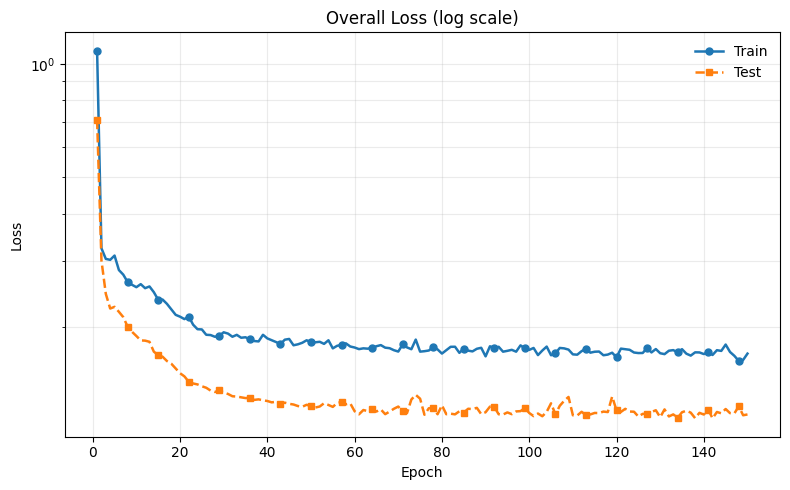

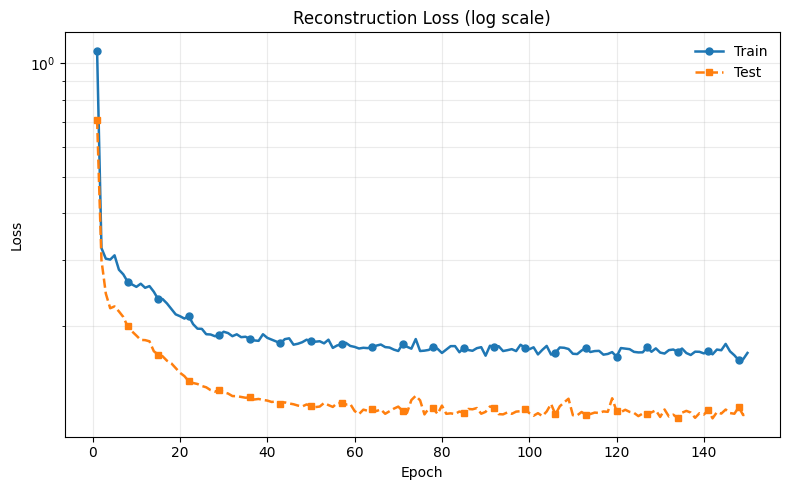

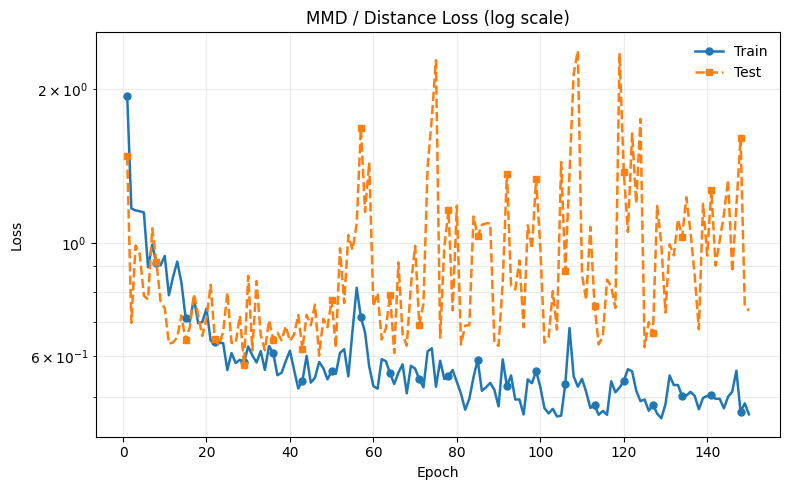

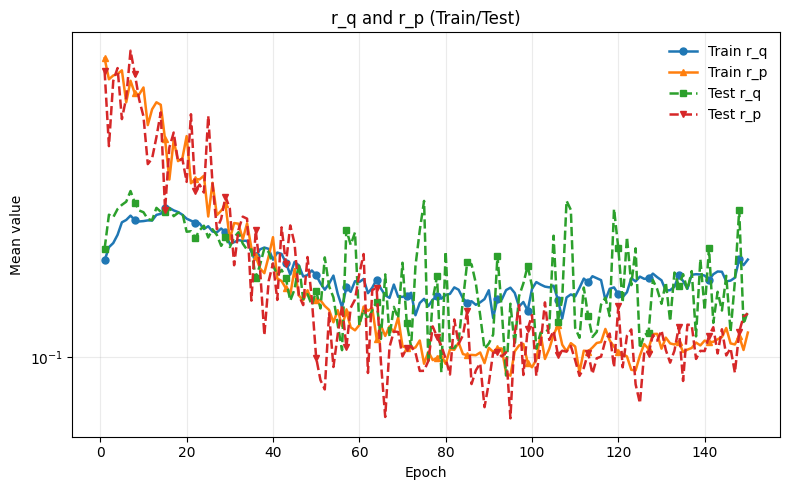

In [81]:
plot_train_test_curves(stats_dict_global, out_dir="vae_v6/checkpoint/poker_dvs/plots", show=True)


------------------------------------Label 2--------------------------------------------
------Original Events------


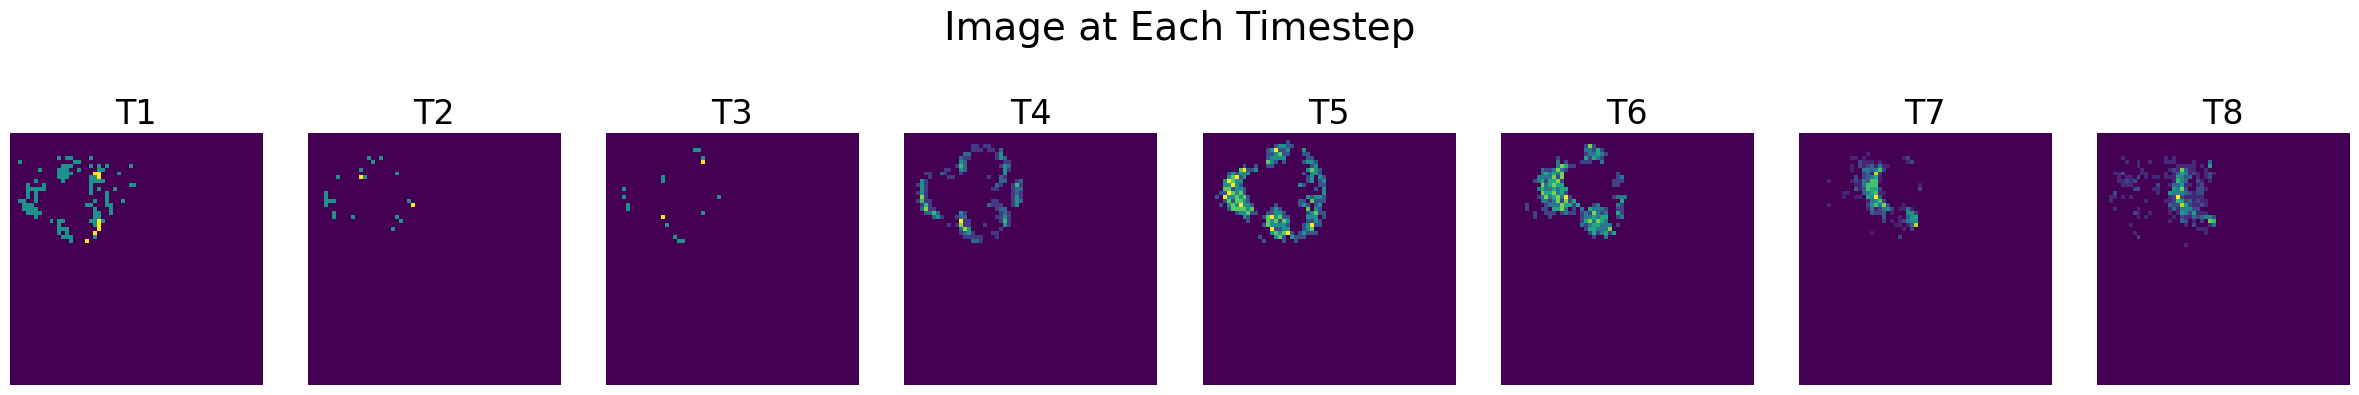

------Reconstructed Output-----


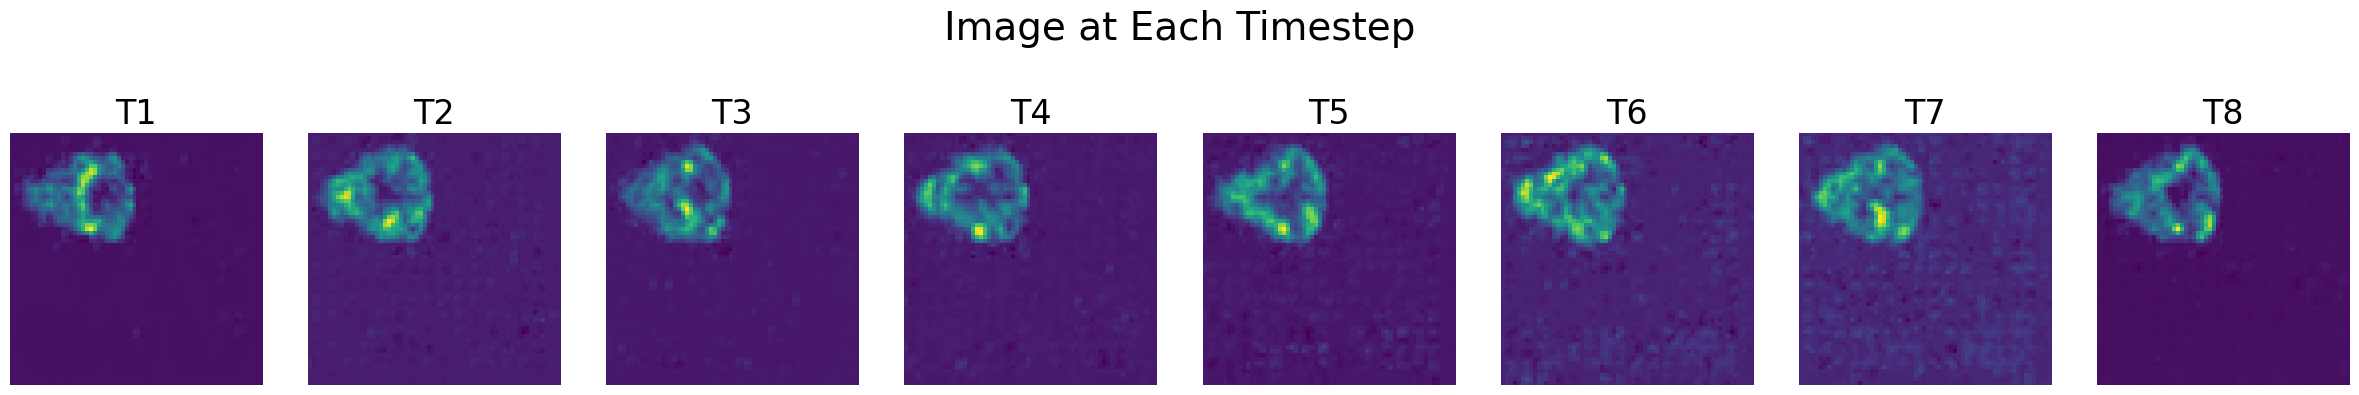

------------------------------------Label 3--------------------------------------------
------Original Events------


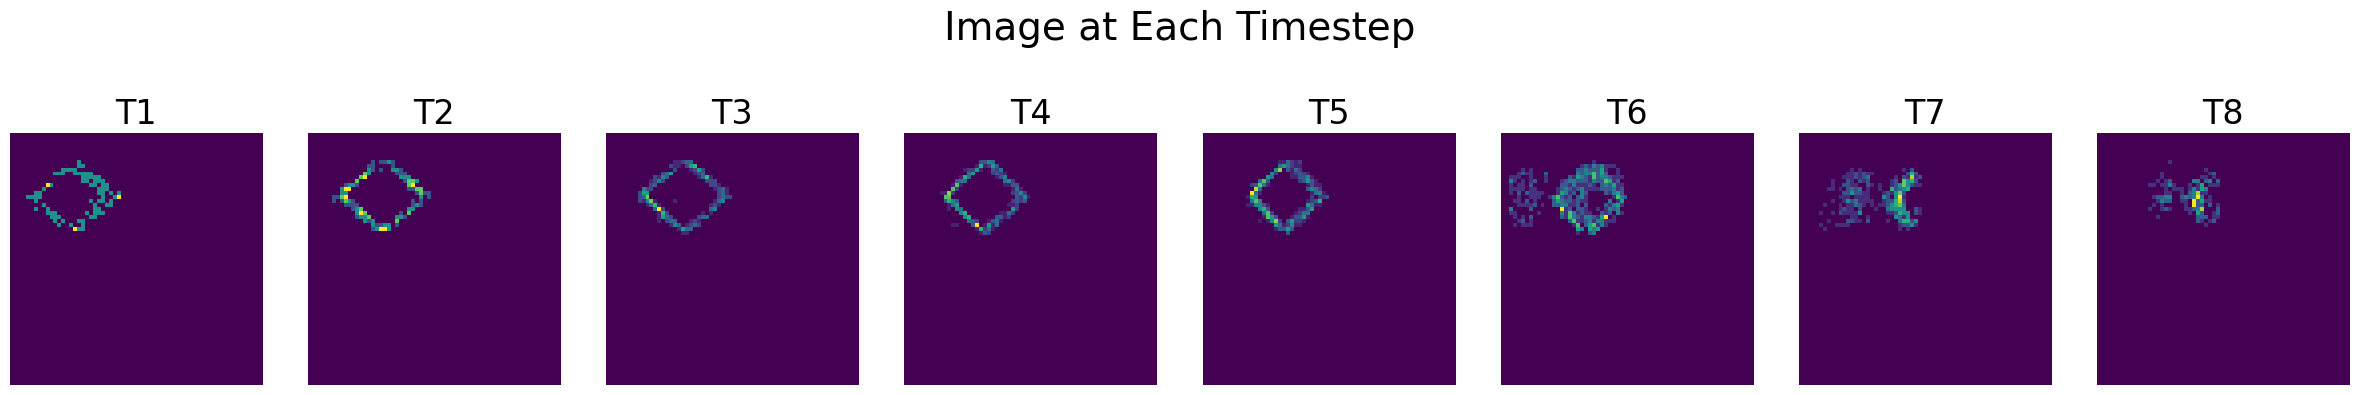

------Reconstructed Output-----


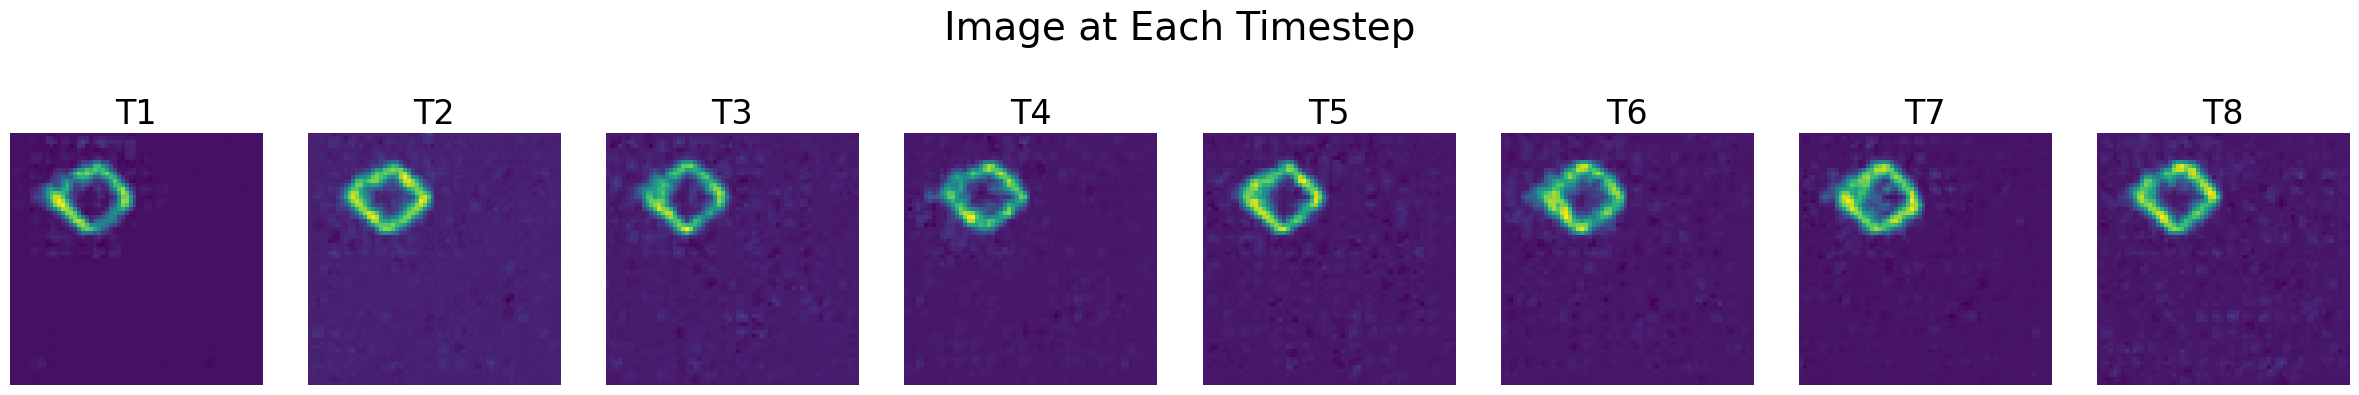

------------------------------------Label 0--------------------------------------------
------Original Events------


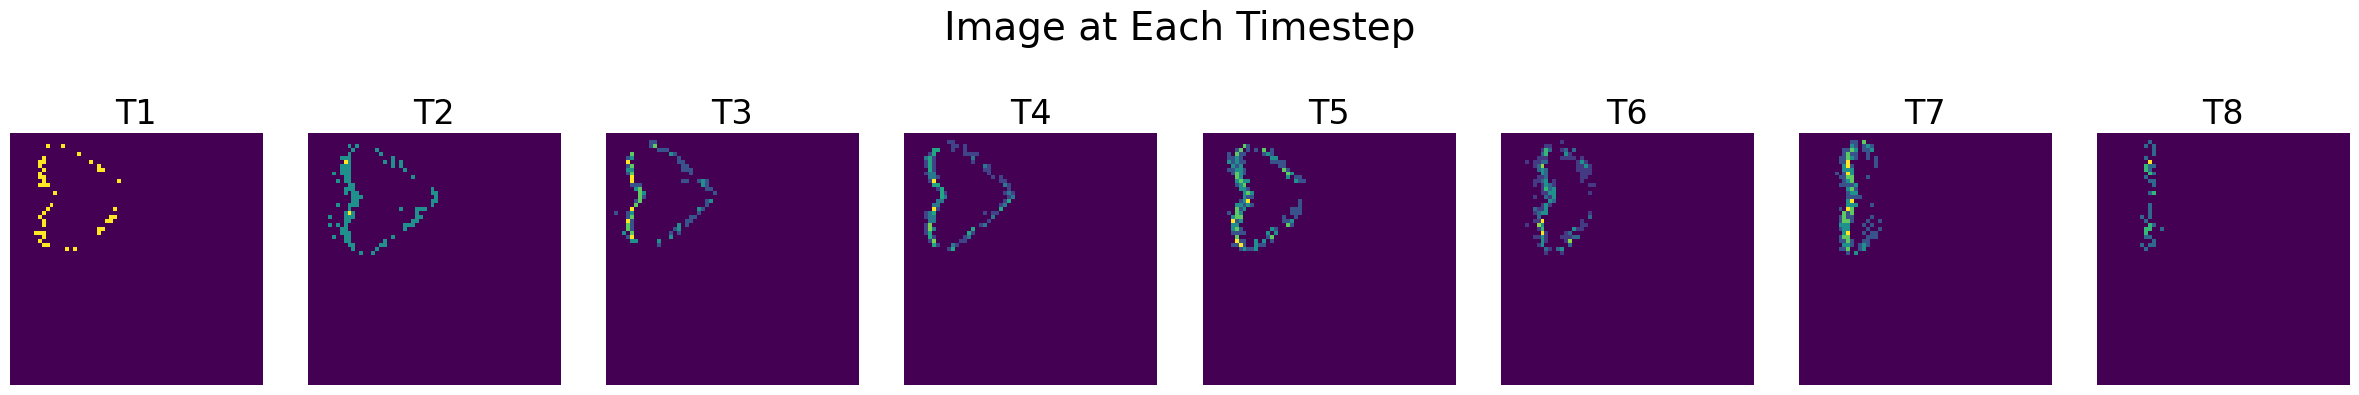

------Reconstructed Output-----


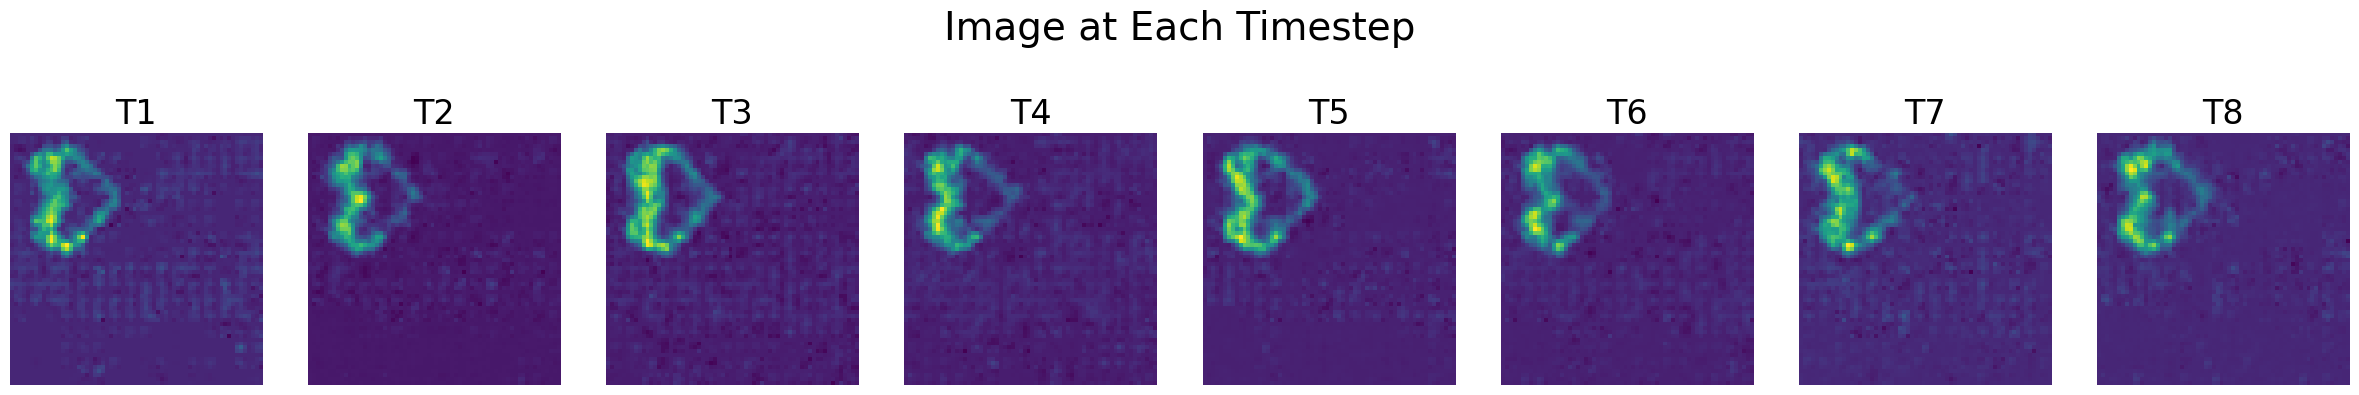

------------------------------------Label 1--------------------------------------------
------Original Events------


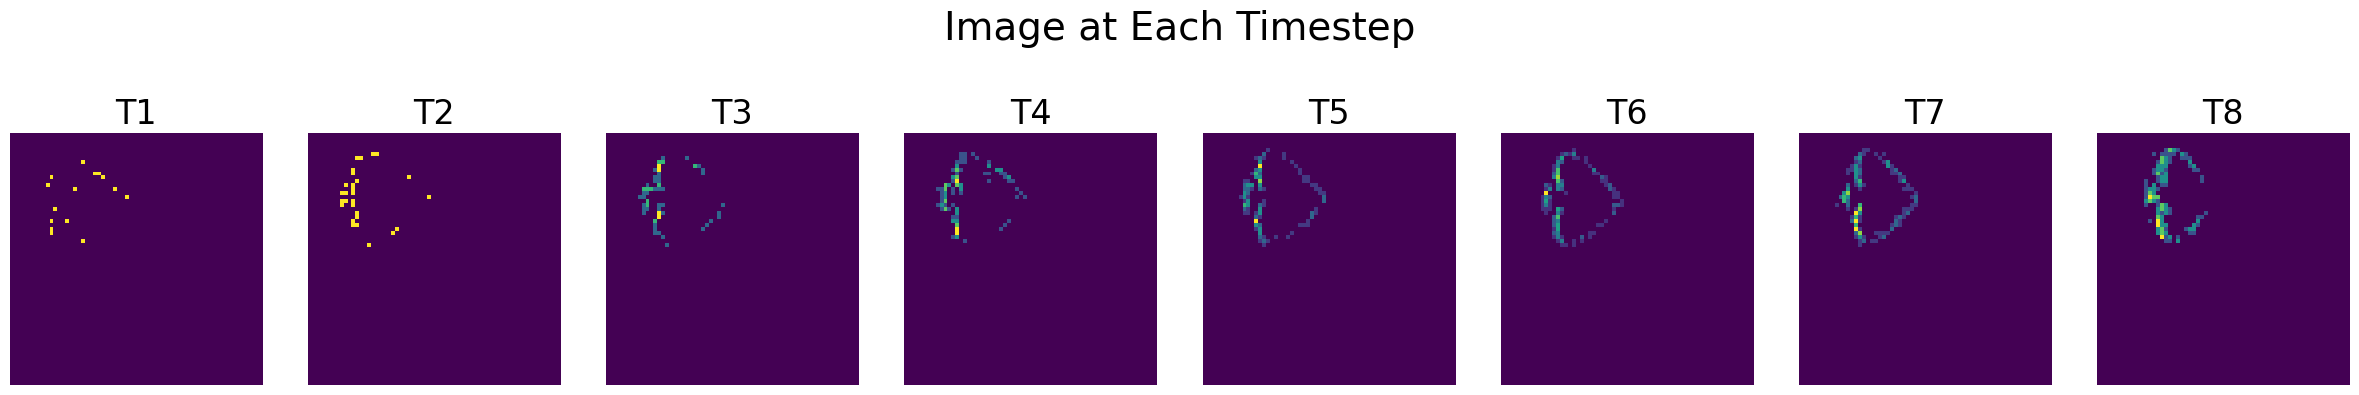

------Reconstructed Output-----


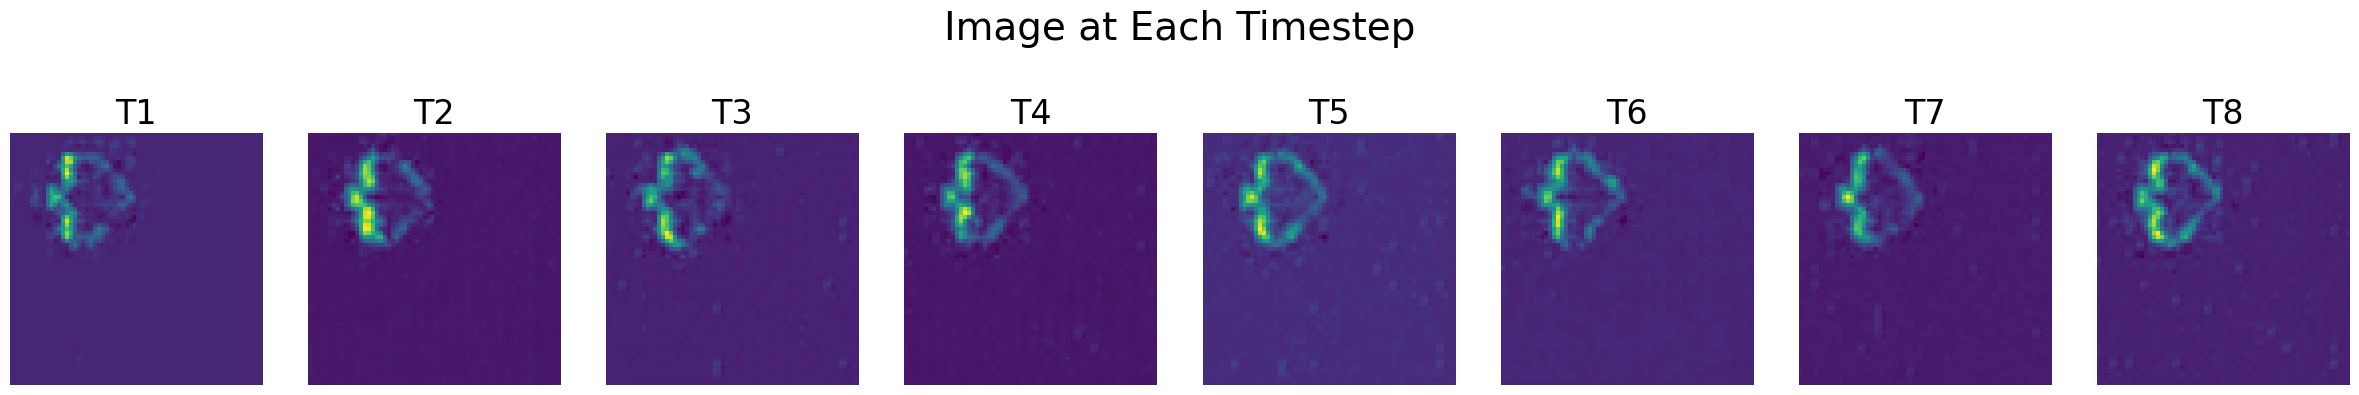

In [88]:
def visualize_suits(network, testloader):
    suite_label = [2, 3, 0, 1]
    network = network.eval()
    with torch.no_grad():
        for batch_idx, (real_img, labels) in enumerate(testloader):
            if len(suite_label) == 0:
                break
            real_img = real_img.to('cuda:0', non_blocking=True)
            labels = labels.to('cuda:0', non_blocking=True)
            spike_input = real_img.unsqueeze(1).float()
            x_recon, r_q, r_p, sampled_z_q = network(spike_input,
                                                  scheduled=True)  # sampled_z (N, latent_dim, T)

            for j in range(len(spike_input)):
                if len(suite_label) == 0:
                    break
                if int(labels[j]) in suite_label:
                    print('------------------------------------Label ' +str(int(labels[j]))+'--------------------------------------------')
                    print('------Original Events------')
                    plot_frames_without_polarity_permuted(spike_input[j][0])
                    print('------Reconstructed Output-----')
                    plot_frames_without_polarity_permuted(x_recon[j][0])
                    suite_label.remove(int(labels[j]))

visualize_suits(net, testloader)


<h3>Visualizing Animation</h3>

In [121]:
network = net.eval()
with torch.no_grad():= 
    real_img, labels = next(iter(trainloader))
    real_img = real_img.to('cuda:0', non_blocking=True)
    labels = labels.to('cuda:0', non_blocking=True)
    spike_input = real_img.unsqueeze(1).float()
    x_recon, r_q, r_p, sampled_z_q = network(spike_input, scheduled=True)

<h4>Animation 1</h4>
Input

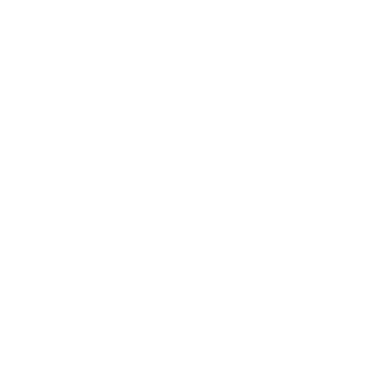

In [90]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[0][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

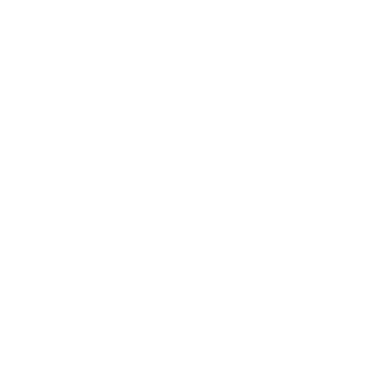

In [91]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[0][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

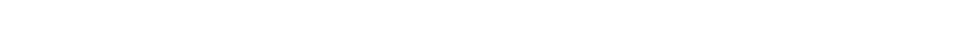

In [99]:

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)  # <- bigger & sharper
ax.set_axis_off()                                # optional: remove axes
anim = splt.animator(sampled_z_q[0].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<h4>Animation 2</h4>
Input

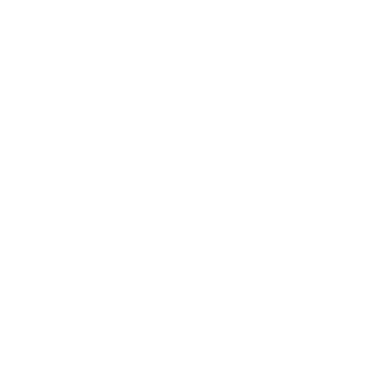

In [100]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[1][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

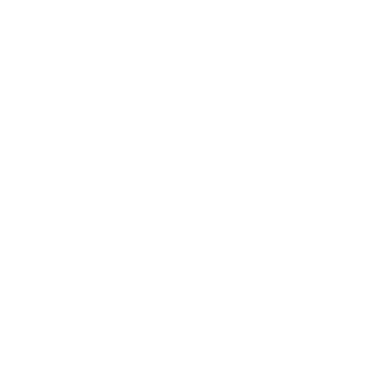

In [101]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[1][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

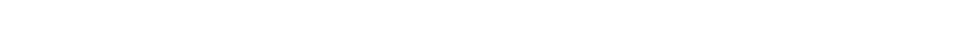

In [102]:

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)  # <- bigger & sharper
ax.set_axis_off()                                # optional: remove axes
anim = splt.animator(sampled_z_q[1].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<h4>Animation 3</h4>
Input

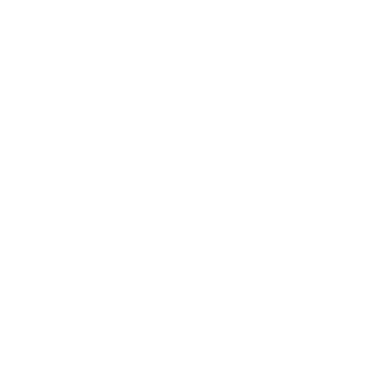

In [105]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[3][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

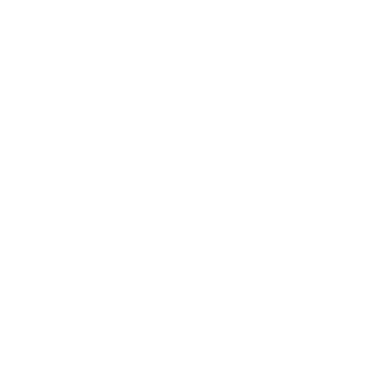

In [106]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[3][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

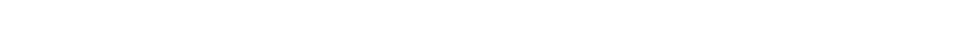

In [107]:

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)  # <- bigger & sharper
ax.set_axis_off()                                # optional: remove axes
anim = splt.animator(sampled_z_q[3].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<h4>Animation 4</h4>
Input

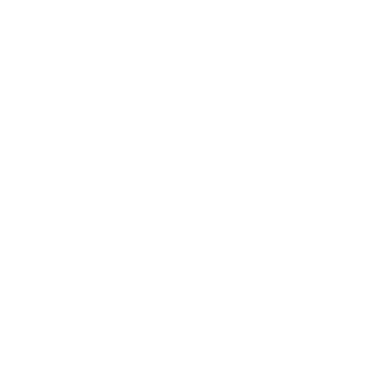

In [131]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[5][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

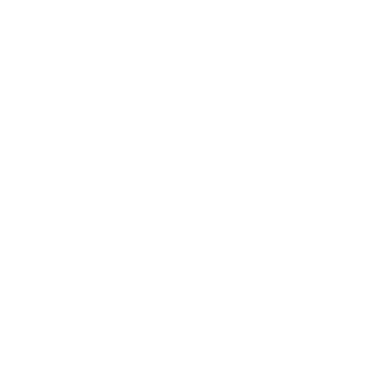

In [132]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[5][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

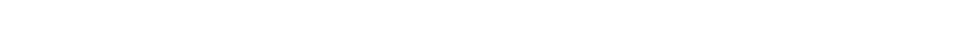

In [133]:
fig, ax = plt.subplots(figsize=(6, 1), dpi=200)  # <- bigger & sharper
ax.set_axis_off()                                # optional: remove axes
anim = splt.animator(sampled_z_q[5].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<H3> Save Model</H3>

In [134]:
torch.save(net.state_dict(), 'vae_poker_dvs_final_model.pt')

<h3>Classifier</h3>

In [136]:
base_model = VAE(mmd_type=mmd_type, n_steps=n_steps, latent_dim=latent_dim)
base_model = base_model.to('cuda:0')
base_model.load_state_dict(torch.load('vae_poker_dvs_final_model.pt', weights_only=True))


<All keys matched successfully>

<h4>Imports</h4>

In [138]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

<h4>Define Classifier</h4>

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAEClassifier(nn.Module):
    """
    Spiking classifier head on top of a frozen VAE encoder.

    Pipeline
    --------
    1) Reuse the pretrained VAE's encoder + time-distributed latent layer to
       produce latent features over time: (N, latent_dim, T).
    2) Convert latent features to spike trains via `gaussian_sample` (rate-coded,
       stochastic thresholding with `SampledSpikeAct`).
    3) Feed spikes through a 3-layer feedforward SNN (Leaky IF neurons with
       learnable decay `beta` and a fast-sigmoid surrogate gradient).
    4) Sum output spikes across time as the class scores.

    Inputs/Outputs
    --------------
    Input  : x ∈ (N, C, H, W, T)
    Output : logits ∈ (N, num_classes)          # sum of spikes over time
              spk3_record ∈ (T, N, num_classes) # per-time-step spike tensor

    Freezing
    --------
    The VAE feature extractor is *frozen*: encoder, latent projection, and
    prior `sample_layer` parameters have `requires_grad=False`.

    Args
    ----
    base_model (VAE): Trained VAE providing `encoder`, `before_latent_layer`,
                      `sample_layer`, `latent_dim`, and `n_steps`.
    num_classes (int): Number of classes for classification.
    device (str): Device used for sampling ops.
    init_beta (float): Initial membrane decay for Leaky IF neurons.

    Notes
    -----
    - `surrogate.fast_sigmoid()` and `snn.Leaky` refer to external SNN libs
      (e.g., snnTorch). They provide the surrogate gradient and spiking neuron.
    - Readout is a spike count (sum over T). You can replace with mean over T
      or max over T if desired.
    """
    def __init__(self, base_model: VAE, num_classes: int = 4, device='cuda:0', init_beta=0.9):
        super().__init__()

        # Use pretrained encoder and latent layer from ESVAE
        self.encoder = base_model.encoder
        self.before_latent_layer = base_model.before_latent_layer
        self.sample_layer = base_model.sample_layer
        self.device = device

        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.before_latent_layer.parameters():
            param.requires_grad = False
        for param in self.sample_layer.parameters():
            param.requires_grad = False

        self.n_steps = base_model.n_steps  # usually 8
        self.latent_dim = base_model.latent_dim  # usually 256

        # Surrogate gradient for spiking nonlinearity
        self.spike_fn = surrogate.fast_sigmoid()

        # --- Spiking classifier ---
        self.lif1 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

        self.fc2 = nn.Linear(self.latent_dim, 128)
        self.lif2 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

        self.fc3 = nn.Linear(128, num_classes)
        self.lif3 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

    def forward(self, x):
        """
        Forward pass.

        1) Encode input video/sequence with frozen VAE encoder.
        2) Project to latent_dim per time step (frozen).
        3) Sample spike trains z_q ∈ (N, latent_dim, T) from posterior rates r_q.
        4) Run z_q through a 3-layer SNN over time and sum output spikes.

        Returns:
            out: (N, num_classes)         # spike counts over time
            spk3_record: (T, N, num_classes)  # per-time-step spikes
        """
        # --- Frozen feature extraction (time-preserving encoder) ---
        x = self.encoder(x)  # shape: (N, C, H, W, T)
        x = torch.flatten(x, start_dim=1, end_dim=3)  # (N, C*H*W, T)
        latent_x = self.before_latent_layer(x)  # (N,latent_dim,T)

        # Posterior sampling: spikes per time step from latent features
        sampled_z_q, r_q, r_p = self.gaussian_sample(latent_x, latent_x.shape[0])
        batch_size = sampled_z_q.size(0)

        # Initialize spiking neuron states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3  = self.lif2.init_leaky()

        spk3_record = []

        # Time unrolling
        for t in range(self.n_steps):
            input_t = sampled_z_q[:, :, t]
            spk1, mem1 = self.lif1(input_t, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_record.append(spk3)

        # Collect spikes over time
        spk3_record = torch.stack(spk3_record, dim=2)  # (B, num_classes, T)
        out = spk3_record.sum(dim=2)  # summed over time
        spk3_record = spk3_record.permute(2, 0, 1)
        return out, spk3_record


    def gaussian_sample(self, latent_x=None, batch_size=None, mu=None, var=None):
        """
        Build posterior and prior rate codes and sample spikes.

        If `latent_x` is provided (q-path):
            - r_p: prior rates from N(0,1) via a frozen Linear+Sigmoid.
            - r_q: posterior rates = mean over time of latent_x (N, D).
            - sampled_z_q: spike trains from r_q replicated over T.

        Else (p-path, for unconditional sampling):
            - r_p: prior rates tiled over time (N, D, T).
            - sampled_z_q: spike trains sampled from r_p.
        """
        if latent_x is not None:
            # Prior rates for MMD term
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)  # (N, latent_dim)
            r_p = self.sample_layer(sampled_z_n)

            # Posterior rates from data; replicate across T and sample spikes
            r_q = latent_x.mean(-1, keepdim=True).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_q)

            r_q = latent_x.mean(-1)   # (N, latent_dim)

            return sampled_z_q, r_q, r_p
        else:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)
            r_p = self.sample_layer(sampled_z_n)
            r_p = r_p.unsqueeze(dim=-1).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_p)
            return sampled_z_q, None, None

<h4>Define Test and Train</h4>

In [143]:
import torch
import torch.nn as nn
from snntorch import functional as SF
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Helper to compute metrics
def compute_metrics(output_spikes, labels):
    # Sum over time: (B, C, T) -> (B, C)
    spike_sum = output_spikes.sum(dim=0)
    preds = spike_sum.argmax(dim=-1).cpu()
    labels = labels.cpu()

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    return acc, f1, precision, recall


# Training loop
def train_one_epoch_classifier(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_metrics = []
    for data, targets in dataloader:
        data = data.to(device)            # shape: (B, C, H, W, T) or (B, input_dim, T)
        targets = targets.to(device)
        spike_input = data.unsqueeze(1).float()
        optimizer.zero_grad()
        logits, spike_record = model(spike_input)   # (B, C, T)
        loss = criterion(spike_record, targets)
        loss.backward()
        optimizer.step()

        acc, f1, precision, recall = compute_metrics(spike_record, targets)
        all_metrics.append((loss.item(), acc, f1, precision, recall))

    mean_metrics = torch.tensor(all_metrics).mean(dim=0)
    return {
        'loss': mean_metrics[0].item(),
        'accuracy': mean_metrics[1].item()
    }


# Evaluation loop
def test_classifier(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_metrics = []
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)
            spike_input = data.unsqueeze(1).float()
            logits, spike_record = model(spike_input)
            loss = criterion(spike_record, targets)

            acc, f1, precision, recall = compute_metrics(spike_record, targets)
            all_metrics.append((loss.item(), acc, f1, precision, recall))

    mean_metrics = torch.tensor(all_metrics).mean(dim=0)
    return {
        'loss': mean_metrics[0].item(),
        'accuracy': mean_metrics[1].item()
    }


<h4>Instantiate Model and Train</h4>

In [152]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAEClassifier(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
criterion = SF.ce_rate_loss()


for epoch in range(10):
    train_metrics = train_one_epoch_classifier(model, trainloader, optimizer, criterion, device)
    test_metrics = test_classifier(model, testloader, criterion, device)

    print(f"Epoch {epoch+1}")
    print("Train:", train_metrics)
    print("Test :", test_metrics)

Epoch 1
Train: {'loss': 1.383156657218933, 'accuracy': 0.15625}
Test : {'loss': 1.3796004056930542, 'accuracy': 0.25}
Epoch 2
Train: {'loss': 1.372837096452713, 'accuracy': 0.15625}
Test : {'loss': 1.3528242111206055, 'accuracy': 0.25}
Epoch 3
Train: {'loss': 1.354618564248085, 'accuracy': 0.2154017857142857}
Test : {'loss': 1.3394362926483154, 'accuracy': 0.3333333333333333}
Epoch 4
Train: {'loss': 1.3257490694522858, 'accuracy': 0.43973214285714285}
Test : {'loss': 1.3059661388397217, 'accuracy': 0.3333333333333333}
Epoch 5
Train: {'loss': 1.270149677991867, 'accuracy': 0.6495535714285714}
Test : {'loss': 1.281692385673523, 'accuracy': 0.5833333333333334}
Epoch 6
Train: {'loss': 1.218005284667015, 'accuracy': 0.78125}
Test : {'loss': 1.2385568618774414, 'accuracy': 0.8333333333333334}
Epoch 7
Train: {'loss': 1.1598025560379028, 'accuracy': 0.890625}
Test : {'loss': 1.1924500465393066, 'accuracy': 0.8333333333333334}
Epoch 8
Train: {'loss': 1.1173825412988663, 'accuracy': 0.8727678571

<h4>Display and Save Metrics</h4>

In [163]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def display_results(model, dataloader, criterion, device, loop='train'):
    model.eval()
    all_metrics = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)
            spike_input = data.unsqueeze(1).float()
            logits, spike_record = model(spike_input)
            loss = criterion(spike_record, targets)

            # Aggregate spikes over time
            spike_sum = spike_record.sum(dim=0)  # (B, C)
            preds = spike_sum.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_metrics.append(loss.item())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification Report
    print("\n📊 Classification Report ("+loop+" Set):")
    # Classification Report
    print("\n📊 Classification Report ("+loop+" Set):")
    print(classification_report(all_labels, all_preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Poker Dvs '+loop+' Dataset: Confusion Matrix')
    # Save the figure
    plt.savefig('confusion_matrix_'+loop+'_data_poker_dvs_full_run.png', dpi=300, bbox_inches='tight')
    plt.show()


    acc = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    return {
        'loss': np.mean(all_metrics),
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }


📊 Classification Report (train Set):

📊 Classification Report (train Set):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     0.8421    1.0000    0.9143        32
           2     1.0000    0.7407    0.8511        27
           3     0.9756    1.0000    0.9877        40

    accuracy                         0.9412       119
   macro avg     0.9544    0.9352    0.9383       119
weighted avg     0.9493    0.9412    0.9390       119



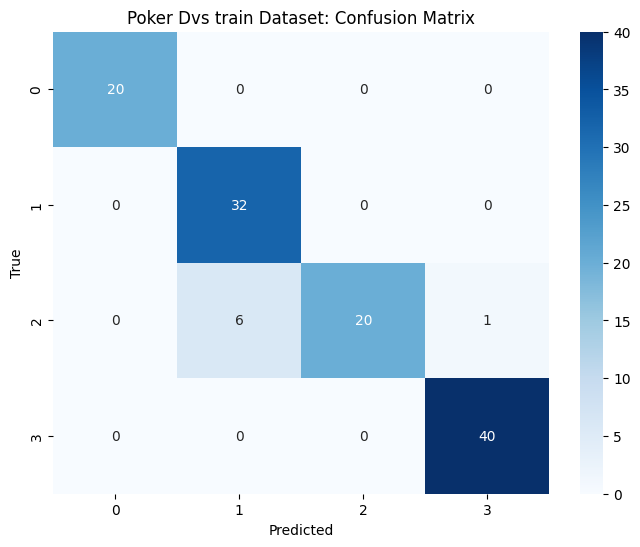

{'loss': 1.022291898727417,
 'accuracy': 0.9411764705882353,
 'f1': 0.9382509662651506,
 'precision': 0.9544287548138639,
 'recall': 0.9351851851851851}

In [164]:
display_results(model, trainloader, criterion, device, loop='train')


📊 Classification Report (test Set):

📊 Classification Report (test Set):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         3
           1     0.7500    1.0000    0.8571         3
           2     1.0000    0.6667    0.8000         3
           3     1.0000    1.0000    1.0000         3

    accuracy                         0.9167        12
   macro avg     0.9375    0.9167    0.9143        12
weighted avg     0.9375    0.9167    0.9143        12



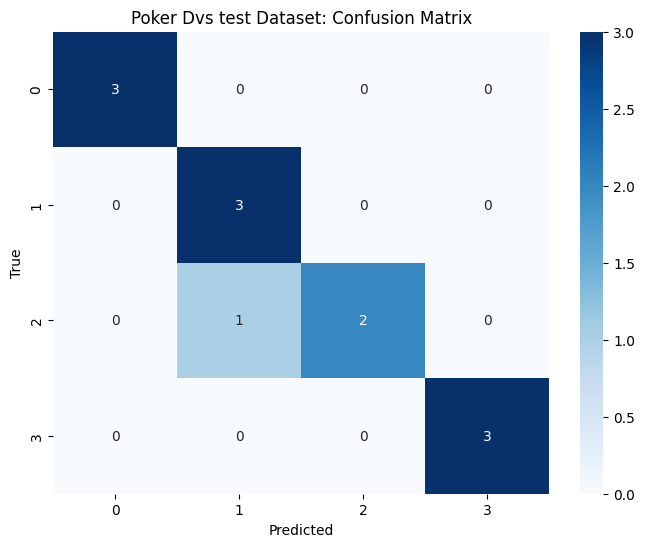

{'loss': 1.125040888786316,
 'accuracy': 0.9166666666666666,
 'f1': 0.9142857142857144,
 'precision': 0.9375,
 'recall': 0.9166666666666666}

In [165]:
display_results(model, testloader, criterion, device, loop='test')

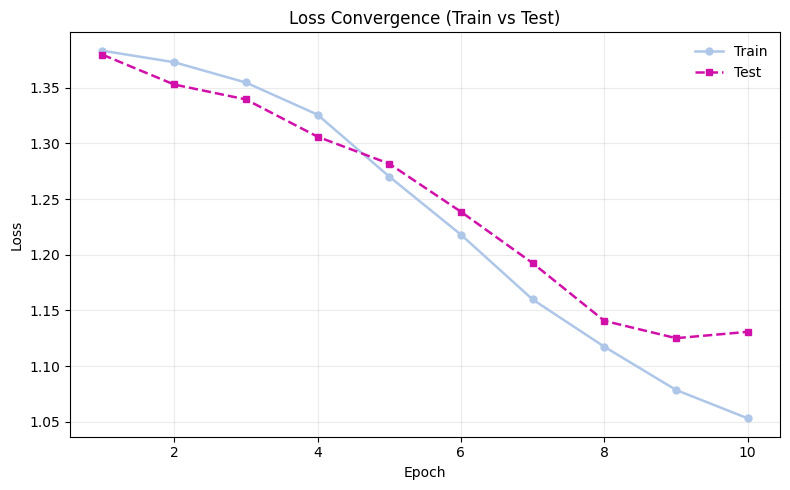

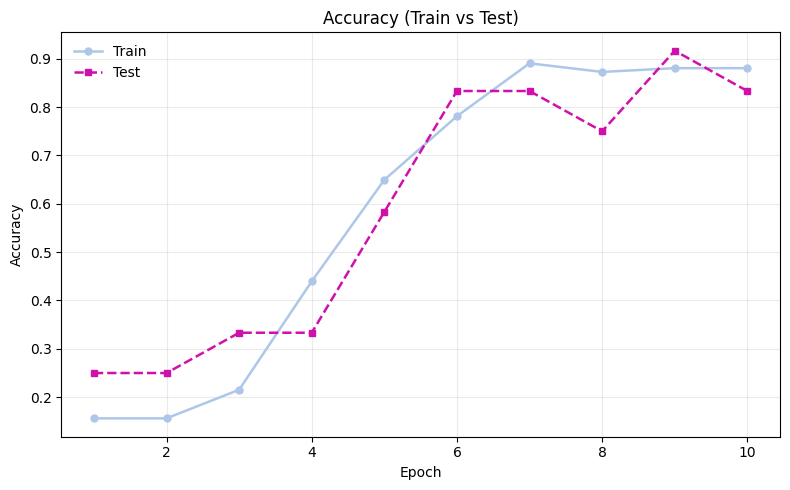

In [161]:
import os
import matplotlib.pyplot as plt

# ---- put your epoch logs here (from your printout) ----
metrics = [
    {"train": {"loss": 1.383156657218933,  "accuracy": 0.15625},
     "test":  {"loss": 1.3796004056930542, "accuracy": 0.25}},
    {"train": {"loss": 1.372837096452713,  "accuracy": 0.15625},
     "test":  {"loss": 1.3528242111206055, "accuracy": 0.25}},
    {"train": {"loss": 1.354618564248085,  "accuracy": 0.2154017857142857},
     "test":  {"loss": 1.3394362926483154, "accuracy": 0.3333333333333333}},
    {"train": {"loss": 1.3257490694522858, "accuracy": 0.43973214285714285},
     "test":  {"loss": 1.3059661388397217, "accuracy": 0.3333333333333333}},
    {"train": {"loss": 1.270149677991867,  "accuracy": 0.6495535714285714},
     "test":  {"loss": 1.281692385673523,  "accuracy": 0.5833333333333334}},
    {"train": {"loss": 1.218005284667015,  "accuracy": 0.78125},
     "test":  {"loss": 1.2385568618774414, "accuracy": 0.8333333333333334}},
    {"train": {"loss": 1.1598025560379028, "accuracy": 0.890625},
     "test":  {"loss": 1.1924500465393066, "accuracy": 0.8333333333333334}},
    {"train": {"loss": 1.1173825412988663, "accuracy": 0.8727678571428572},
     "test":  {"loss": 1.1406490802764893, "accuracy": 0.75}},
    {"train": {"loss": 1.0785570591688156, "accuracy": 0.8805803571428572},
     "test":  {"loss": 1.125054955482483,  "accuracy": 0.9166666666666666}},
    {"train": {"loss": 1.0530773401260376, "accuracy": 0.8805803571428572},
     "test":  {"loss": 1.130749225616455,  "accuracy": 0.8333333333333334}},
]


# ---- extract series ----
epochs = list(range(1, len(metrics) + 1))
train_loss = [m["train"]["loss"] for m in metrics]
test_loss  = [m["test"]["loss"]  for m in metrics]
train_acc  = [m["train"]["accuracy"] for m in metrics]
test_acc   = [m["test"]["accuracy"]  for m in metrics]

# ---- plotting helpers ----
def plot_two(x, y1, y2, title, ylabel, fname=None):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, y1, marker="o", lw=1.8, ms=5, label="Train", color="#AEC7E8")
    ax.plot(x, y2, marker="s", lw=1.8, ms=5, linestyle="--", label="Test", color="#d110AA")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(frameon=False)
    fig.tight_layout()
    if fname:
        os.makedirs(os.path.dirname(fname), exist_ok=True)
        fig.savefig(fname, bbox_inches="tight", dpi=160)
    plt.show()

# ---- make the plots (and optionally save) ----
out_dir = "vae_v6/checkpoint/poker_dvs/classification/plots"  # change or set to None if you don't want files
plot_two(epochs, train_loss, test_loss,
         title="Loss Convergence (Train vs Test)", ylabel="Loss",
         fname=os.path.join(out_dir, "loss_convergence.png") if out_dir else None)

plot_two(epochs, train_acc, test_acc,
         title="Accuracy (Train vs Test)", ylabel="Accuracy",
         fname=os.path.join(out_dir, "accuracy.png") if out_dir else None)


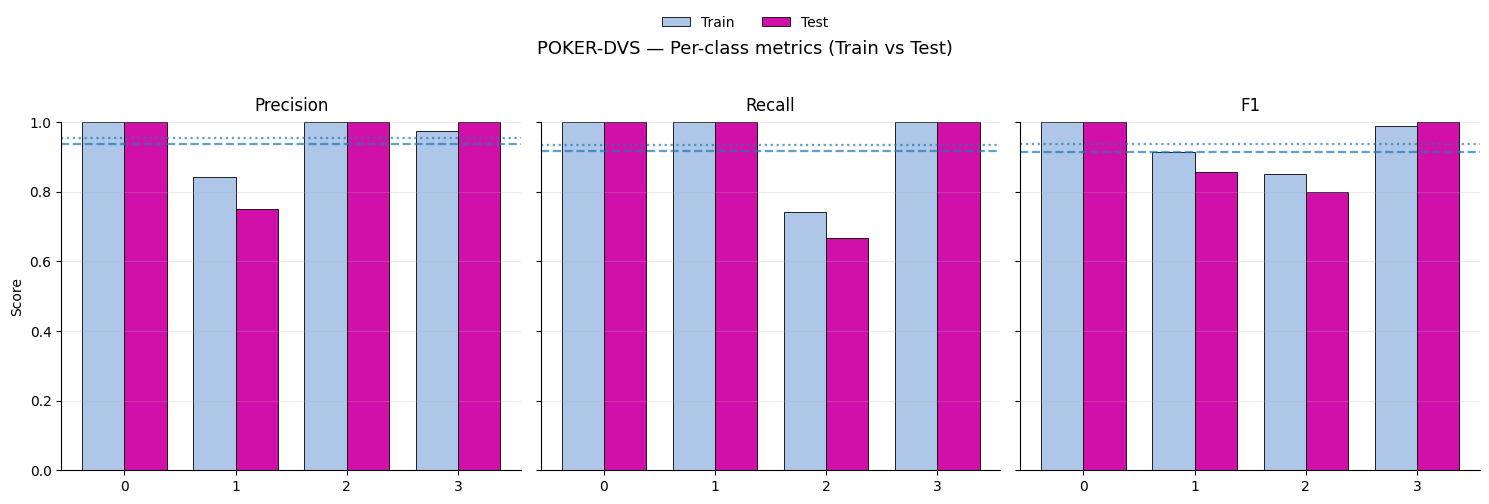

In [166]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ===== paste your numbers =====
classes = [str(i) for i in range(4)]

train = {
    "precision": [1.0000, 0.8421, 1.0000, 0.9756],
    "recall":    [1.0000, 1.0000, 0.7407, 1.0000],
    "f1":        [1.0000, 0.9143, 0.8511, 0.9877],
    "macro":     {"precision": 0.9544, "recall": 0.9352, "f1": 0.9383},
    "weighted":  {"precision": 0.9493, "recall": 0.9412, "f1": 0.9390},
    "support":   [20, 32, 27, 40],
    "accuracy":  0.9412,
}

test = {
    "precision": [1.0000, 0.7500, 1.0000, 1.0000],
    "recall":    [1.0000, 1.0000, 0.6667, 1.0000],
    "f1":        [1.0000, 0.8571, 0.8000, 1.0000],
    "macro":     {"precision": 0.9375, "recall": 0.9167, "f1": 0.9143},
    "weighted":  {"precision": 0.9375, "recall": 0.9167, "f1": 0.9143},
    "support":   [3, 3, 3, 3],
    "accuracy":  0.9167,
}
# =================================

def plot_per_class_grid(train, test, classes, suptitle="Per-class metrics (Train vs Test)",
                        out_path=None, bar_width=0.38):
    metrics = ["precision", "recall", "f1"]
    x = np.arange(len(classes))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4.6), sharey=True)
    for ax, metric in zip(axes, metrics):
        # Bars
        ax.bar(x - bar_width/2, train[metric], width=bar_width, label="Train", color="#AEC7E8",
               edgecolor="black", linewidth=0.6),
        ax.bar(x + bar_width/2, test[metric],  width=bar_width, label="Test", color="#d110AA", 
               edgecolor="black", linewidth=0.6)

        # Macro-average guide lines
        ax.axhline(train["macro"][metric], linestyle=":", linewidth=1.6, alpha=0.7)
        ax.axhline(test["macro"][metric],  linestyle="--", linewidth=1.6, alpha=0.7)

        # Cosmetics
        ax.set_title(metric.capitalize(), pad=8)
        ax.set_xticks(x, classes)
        ax.set_ylim(0, 1.0)
        ax.grid(True, axis="y", alpha=0.25)
        for spine in ("top", "right"):
            ax.spines[spine].set_visible(False)

    axes[0].set_ylabel("Score")
    fig.suptitle(suptitle, y=1.02, fontsize=13)

    # Single legend above subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncols=2, frameon=False, bbox_to_anchor=(0.5, 1.10))

    fig.tight_layout()
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, dpi=180, bbox_inches="tight")
    plt.show()

# Use it
plot_per_class_grid(train, test, classes, suptitle="POKER-DVS — Per-class metrics (Train vs Test)",
                    out_path="vae_v6/checkpoint/poker_dvs/classification/plots/poker_dvs_per_class_metrics.png")


In [167]:
torch.save(model.state_dict(), 'vae_clf_poker_dvs_final_model.pt')

In [172]:
net.eval()

# 3. Count trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in net.parameters() if not p.requires_grad)

print(f"Total Trainable Parameters: {trainable_params:,}")
print(f"Total Non-Trainable Parameters: {non_trainable_params:,}")
print(f"Total Parameters: {trainable_params + non_trainable_params:,}")

Total Trainable Parameters: 17,091,457
Total Non-Trainable Parameters: 0
Total Parameters: 17,091,457


In [171]:
model.eval()
# 3. Count trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Total Trainable Parameters: {trainable_params:,}")
print(f"Total Non-Trainable Parameters: {non_trainable_params:,}")
print(f"Total Parameters: {trainable_params + non_trainable_params:,}")

Total Trainable Parameters: 33,415
Total Non-Trainable Parameters: 8,530,048
Total Parameters: 8,563,463
